C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


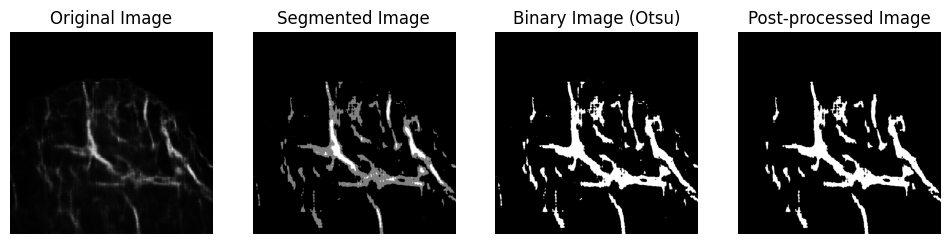

In [1]:
# 필요한 라이브러리 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 이미지 파일 경로
image_path = 'C:/Users/User/Desktop/image/0-0.png'

# 이미지 읽기 (그레이스케일)
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 이미지를 1차원으로 변환
pixels = original_image.reshape(-1, 1)

# K-평균 클러스터링
k = 3  # 클러스터의 수
kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
# 클러스터 레이블을 원본 이미지 크기로 변환
segmented_image = kmeans.labels_.reshape(original_image.shape)
# 오츠 알고리즘을 사용한 이진화
otsu_threshold, binary_image = cv2.threshold(segmented_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



# 작은 구성 요소 제거 함수 정의
def remove_small_components(binary_image):
    num_labels, labels = cv2.connectedComponents(binary_image)
    output_image = np.zeros_like(binary_image)
    component_sizes = []

    # 각 연결 성분의 크기 계산
    for label in range(1, num_labels):
        component_mask = (labels == label)
        component_size = np.sum(component_mask)
        component_sizes.append(component_size)

    # 이상치 제거를 위한 Z-스코어 계산
    if component_sizes:
        mean_size = np.mean(component_sizes)
        std_size = np.std(component_sizes)

        # Z-스코어가 특정 임계값을 넘는 성분만 유지 (예: |Z| < 2)
        threshold = 2  # 필요에 따라 조정 가능
        filtered_sizes = [size for size in component_sizes if abs((size - mean_size) / std_size) < threshold]

        # 이상치를 제거한 후 평균 크기 계산
        if filtered_sizes:
            filtered_mean_size = np.mean(filtered_sizes)
        else:
            filtered_mean_size = 0

        # 이상치를 제거한 후 평균 크기보다 큰 성분만 남기기
        for label in range(1, num_labels):
            component_mask = (labels == label)
            component_size = np.sum(component_mask)
            if component_size > filtered_mean_size:
                output_image[component_mask] = 255
    else:
        filtered_mean_size = 0

    return output_image, filtered_mean_size

output_image, average_size = remove_small_components(binary_image)

# 결과를 화면에 표시
plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# K-평균 클러스터링 결과
plt.subplot(1, 4, 2)
plt.title('Segmented Image')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

# 오츠 이진화된 이미지
plt.subplot(1, 4, 3)
plt.title('Binary Image (Otsu)')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

# 작은 구성 요소 제거 결과
plt.subplot(1, 4, 4)
plt.title('Post-processed Image')
plt.imshow(output_image, cmap='gray')
plt.axis('off')

plt.show()


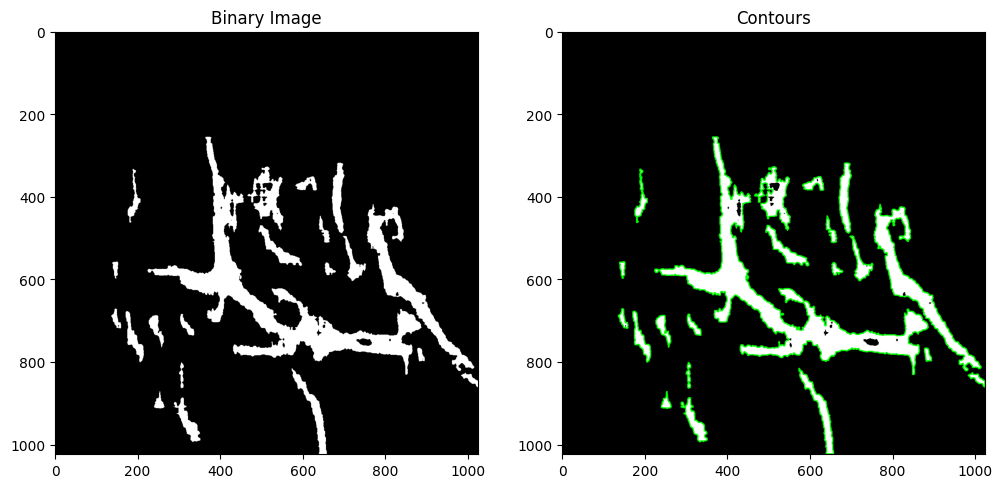

Contour 0: Mean pixel value = 36.760226283724975
Contour 1: Mean pixel value = 30.94851485148515
Contour 2: Mean pixel value = 30.051851851851854
Contour 3: Mean pixel value = 55.35911158683436
Contour 4: Mean pixel value = 26.784946236559144
Contour 5: Mean pixel value = 30.49484536082474
Contour 6: Mean pixel value = 35.16637010676156
Contour 7: Mean pixel value = 28.362844702467346
Contour 8: Mean pixel value = 32.355447680690396
Contour 9: Mean pixel value = 31.79657794676806
Contour 10: Mean pixel value = 31.77699530516432
Contour 11: Mean pixel value = 35.89267015706807
Contour 12: Mean pixel value = 44.564293304994685
Contour 13: Mean pixel value = 41.380506822612084
Contour 14: Mean pixel value = 30.598765432098762
Contour 15: Mean pixel value = 72.40122186896079
Contour 16: Mean pixel value = 32.51052631578947
Contour 17: Mean pixel value = 33.129582267689685
Contour 18: Mean pixel value = 31.228686233403213
Contour 19: Mean pixel value = 75.17284345047923
Contour 20: Mean pix

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 윤곽선 검출
contours, _ = cv2.findContours(output_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 윤곽선 그리기
contour_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# 각 컨투어의 평균 화소값 계산 및 정보 저장
contour_data = []
mean_pixel_values = []

for i, contour in enumerate(contours):
    mask = np.zeros_like(output_image)
    cv2.drawContours(mask, [contour], -1, 255, -1)  # 컨투어를 흰색으로 채운 마스크 생성
    mean_val = cv2.mean(original_image, mask=mask)[0]  # 마스크 영역의 평균 화소값 계산 (원본 이미지 사용)
    mean_pixel_values.append(mean_val)
    
    # 컨투어의 중심점 계산
    M = cv2.moments(contour)
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = contour[0][0]
    
    # 컨투어 데이터 저장
    contour_info = {
        "contour_index": i,
        "contour_points": contour.tolist(),
        "mean_pixel_value": mean_val,
        "center": [center_x, center_y]
    }
    contour_data.append(contour_info)

# 결과 시각화
plt.figure(figsize=(12, 6))

# 원본 이진화 이미지
plt.subplot(1, 2, 1)
plt.imshow(output_image, cmap='gray')
plt.title('Binary Image')

# 윤곽선 이미지
plt.subplot(1, 2, 2)
plt.imshow(contour_image)
plt.title('Contours')

plt.show()

# 평균 화소값 출력
for i, mean_val in enumerate(mean_pixel_values):
    print(f"Contour {i}: Mean pixel value = {mean_val}")

# contour_data 리스트에 컨투어 정보가 저장됨


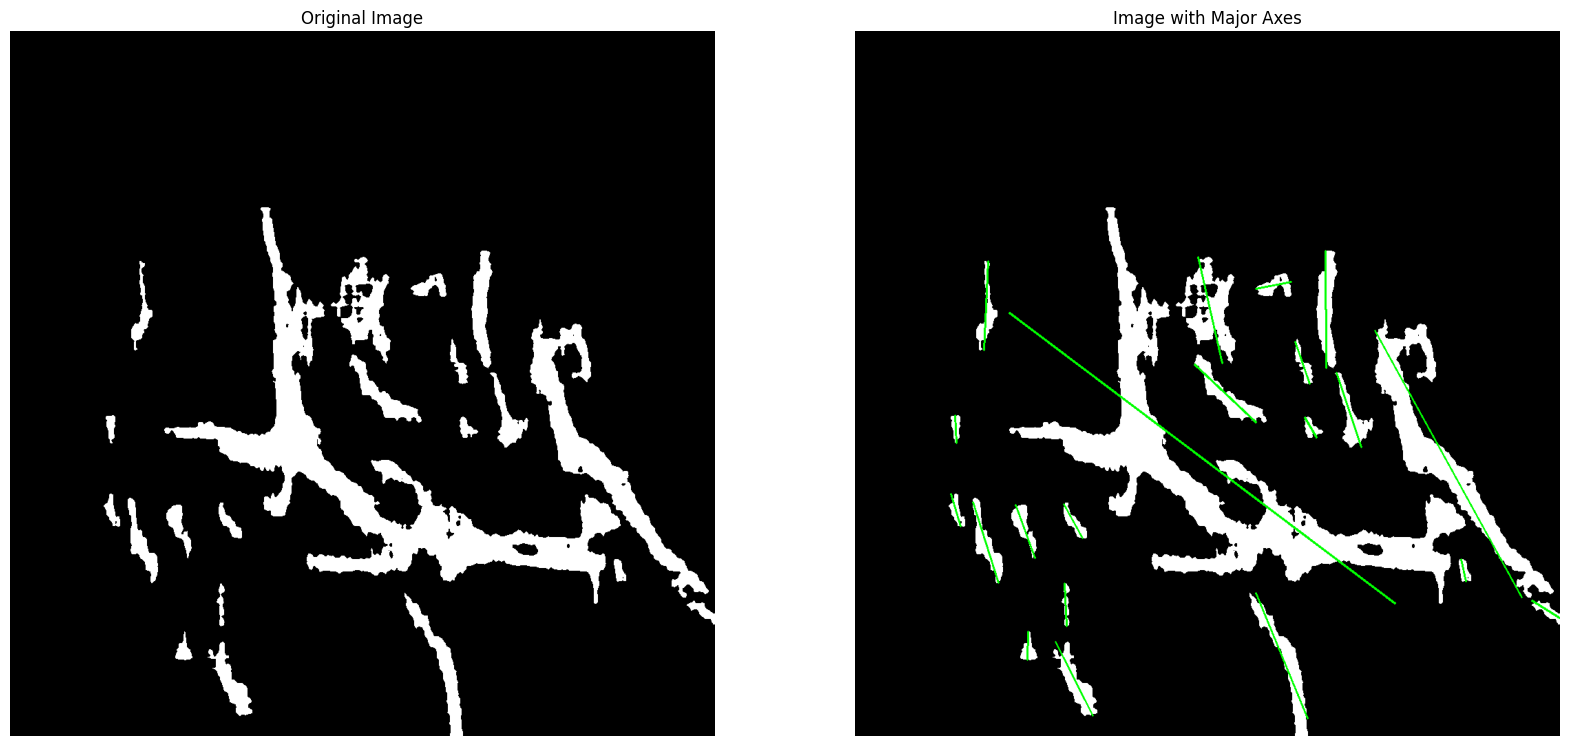

Contour 0: Mean pixel value = 36.760226283724975, PCA angle (radians) = 1.1065579642727497, Center = (321, 946)
Contour 1: Mean pixel value = 30.94851485148515, PCA angle (radians) = 1.5956282262249004, Center = (251, 900)
Contour 2: Mean pixel value = 30.051851851851854, PCA angle (radians) = -2.5725699645675135, Center = (1005, 841)
Contour 3: Mean pixel value = 55.35911158683436, PCA angle (radians) = 1.1824500434788427, Center = (626, 923)
Contour 4: Mean pixel value = 26.784946236559144, PCA angle (radians) = 1.5360916736649302, Center = (306, 833)
Contour 5: Mean pixel value = 30.49484536082474, PCA angle (radians) = 1.3602630342926212, Center = (884, 783)
Contour 6: Mean pixel value = 35.16637010676156, PCA angle (radians) = 1.2134481474301222, Center = (244, 717)
Contour 7: Mean pixel value = 28.362844702467346, PCA angle (radians) = 1.0515020312088108, Center = (318, 714)
Contour 8: Mean pixel value = 32.355447680690396, PCA angle (radians) = 1.2603339043190516, Center = (190,

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

def calculate_pca(contour):
    data_pts = np.array(contour, dtype=np.float64).reshape(-1, 2)
    mean = np.mean(data_pts, axis=0)
    centered_data_pts = data_pts - mean
    cov_matrix = np.cov(centered_data_pts, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    major_axis = eigenvectors[:, -1]
    angle = np.arctan2(major_axis[1], major_axis[0])
    return angle

def extend_line_within_bounds(center, angle, x_min, x_max, y_min, y_max):
    direction = np.array([np.cos(angle), np.sin(angle)])
    scale_factors = []
    if direction[0] != 0:
        scale_factors.extend([
            (x_min - center[0]) / direction[0],
            (x_max - center[0]) / direction[0]
        ])
    if direction[1] != 0:
        scale_factors.extend([
            (y_min - center[1]) / direction[1],
            (y_max - center[1]) / direction[1]
        ])
    if not scale_factors:
        return tuple(center), tuple(center)
    positive_scales = [sf for sf in scale_factors if sf > 0]
    negative_scales = [sf for sf in scale_factors if sf < 0]
    min_scale = max(negative_scales) if negative_scales else 0
    max_scale = min(positive_scales) if positive_scales else 1
    start_point = center + direction * min_scale
    end_point = center + direction * max_scale
    start_point = np.clip(start_point, [x_min, y_min], [x_max, y_max])
    end_point = np.clip(end_point, [x_min, y_min], [x_max, y_max])
    return tuple(start_point.astype(int)), tuple(end_point.astype(int))

def draw_gradients_on_image(image, contours):
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    pca_angles = []
    centers = []
    lines_info = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = tuple(contour[0][0])
        centers.append((center_x, center_y))
        angle = calculate_pca(contour)
        pca_angles.append(angle)
        contour_array = np.array(contour).reshape(-1, 2)
        x_min, y_min = contour_array.min(axis=0)
        x_max, y_max = contour_array.max(axis=0)
        start_point, end_point = extend_line_within_bounds(
            np.array([center_x, center_y]), angle, 
            x_min, x_max, y_min, y_max
        )
        cv2.line(color_image, start_point, end_point, (0, 255, 0), 2)
        lines_info.append({
            'start': start_point,
            'end': end_point,
            'center': (center_x, center_y),
        })
    return color_image, pca_angles, centers, lines_info

# 주성분선 그리기 및 주성분선 기울기 및 중심점 계산
gradient_image, pca_angles, centers, lines_info = draw_gradients_on_image(output_image, contours)

# 결과 시각화
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Image with Major Axes')
plt.imshow(gradient_image)
plt.axis('off')
plt.show()

# 평균 화소값 및 주성분선 기울기 및 중심점 좌표 출력
for i, (mean_val, angle, center) in enumerate(zip(mean_pixel_values, pca_angles, centers)):
    print(f"Contour {i}: Mean pixel value = {mean_val}, PCA angle (radians) = {angle}, Center = {center}")

# 컨투어 데이터를 JSON 형식으로 변환
cluster_data = {
    'contours': [
        {
            'index': i,
            'mean_pixel_value': mean_val,
            'pca_angle': angle,
            'contour': contour.tolist(),
            'line': {
                'start': lines_info[i]['start'],
                'end': lines_info[i]['end'],
                'center': lines_info[i]['center'],
            }
        }
        for i, (mean_val, angle, center) in enumerate(zip(mean_pixel_values, pca_angles, centers))
    ]
}

# JSON 파일로 저장
def convert_np_types(o):
    if isinstance(o, (np.int32, np.int64)): return int(o)
    if isinstance(o, (np.float32, np.float64)): return float(o)
    if isinstance(o, np.ndarray): return o.tolist()
    raise TypeError

json_file_path = 'contours_data.json'
with open(json_file_path, 'w') as json_file:
    json.dump(cluster_data, json_file, indent=4, default=convert_np_types)

print(f"Data has been saved to {json_file_path}")


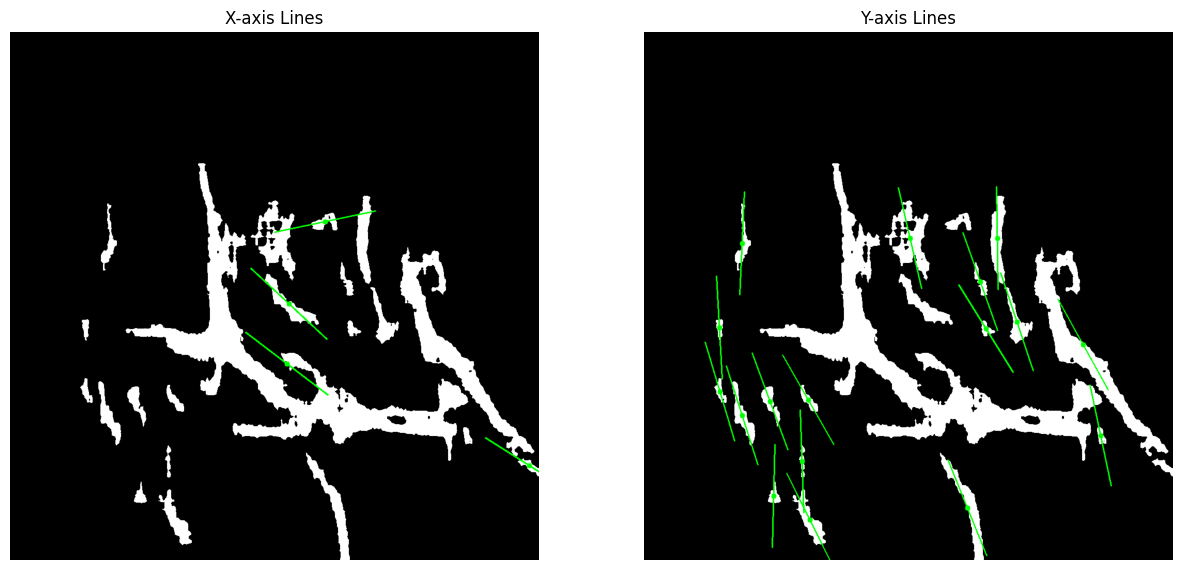

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



def draw_gradients_on_image(image, contours):
    """
    Draw the major axis direction on the image for each contour.
    
    :param image: Input grayscale image.
    :param contours: List of contours.
    :return: Image with gradients drawn and list of PCA angles, centers, start and end points.
    """
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    pca_angles = []  # List to store PCA angles for each contour
    centers = []  # List to store center coordinates for each contour
    lines_info = []  # List to store start and end points for each line

    for contour in contours:
        # Calculate the center of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = tuple(contour[0][0])
        
        centers.append((center_x, center_y))

        # Calculate the major axis angle using PCA
        angle = calculate_pca(contour)
        pca_angles.append(angle)  # Save the PCA angle

        length = 100  # Length of the line to draw
        
        start_x = int(center_x - length * np.cos(angle))
        start_y = int(center_y - length * np.sin(angle))
        
        end_x = int(center_x + length * np.cos(angle))
        end_y = int(center_y + length * np.sin(angle))

        cv2.line(color_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        
        # Store the start, end, and center points
        lines_info.append({
            'start': (start_x, start_y),
            'end': (end_x, end_y),
            'center': (center_x, center_y),
            'angle': angle
        })

    return color_image, lines_info

def group_lines_by_angle(lines, threshold_angle=np.radians(45)):
    x_axis_lines = []
    y_axis_lines = []
    
    for line in lines:
        angle = line['angle']
        if abs(angle) < threshold_angle or abs(angle) > (np.pi - threshold_angle):
            x_axis_lines.append(line)
        else:
            y_axis_lines.append(line)
    
    return x_axis_lines, y_axis_lines

def draw_lines_on_image(image, lines, color):
    """
    Draw lines on the image.
    :param image: Input image.
    :param lines: List of line information (start, end, center, angle).
    :param color: Color of the lines (BGR format).
    :return: Image with lines drawn.
    """
    if len(image.shape) == 2:  # If the image is grayscale
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        color_image = image.copy()
    
    for line in lines:
        start, end, center, _ = line.values()
        cv2.line(color_image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), color, 2)
        cv2.circle(color_image, (int(center[0]), int(center[1])), 5, color, -1)  # Mark the center

    return color_image

# Assuming output_image and contours are already defined
gradient_image, lines_info = draw_gradients_on_image(output_image, contours)

# Group lines by angle
x_axis_lines, y_axis_lines = group_lines_by_angle(lines_info)

# Draw grouped lines on the image
x_axis_image = draw_lines_on_image(output_image, x_axis_lines, (0, 255, 0))  # Red
y_axis_image = draw_lines_on_image(output_image, y_axis_lines, (0, 255, 0))  # Green

# Display results
plt.figure(figsize=(15, 10))

# X-axis lines
plt.subplot(1, 2, 1)
plt.title('X-axis Lines')
plt.imshow(cv2.cvtColor(x_axis_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')

# Y-axis lines
plt.subplot(1, 2, 2)
plt.title('Y-axis Lines')
plt.imshow(cv2.cvtColor(y_axis_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')

plt.show()


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

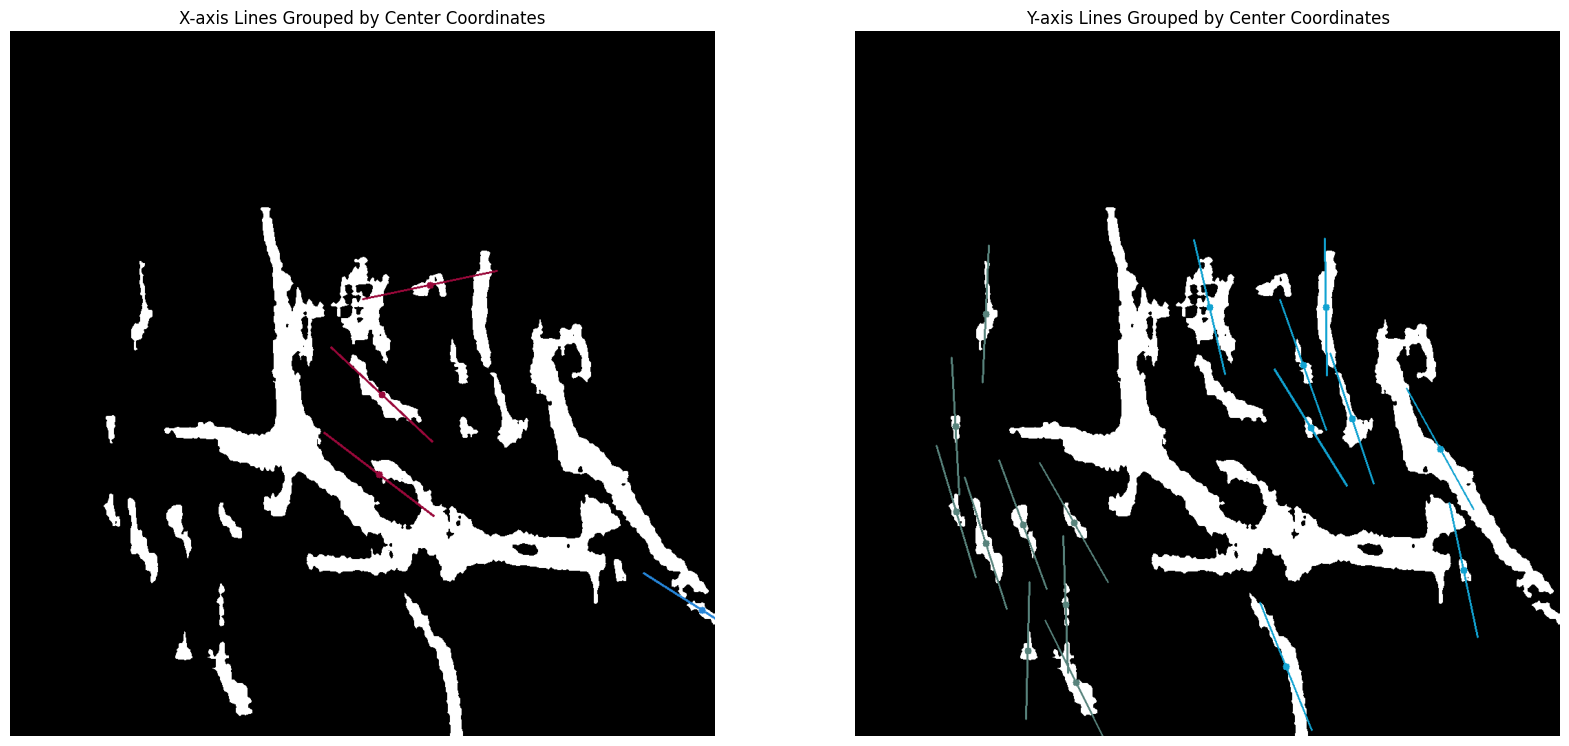

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def find_optimal_num_groups(data, max_groups=10):
    """
    Determine the optimal number of groups for clustering using the Elbow Method.
    """
    sse = []
    num_samples = data.shape[0]
    
    # Ensure max_groups does not exceed number of samples
    max_groups = min(max_groups, num_samples)
    
    if max_groups < 2:
        # If there are too few points for clustering, return 1 as the optimal number
        return 1

    for num_groups in range(1, max_groups + 1):
        kmeans = KMeans(n_clusters=num_groups, random_state=0).fit(data)
        sse.append(kmeans.inertia_)
    
    # If the sse list has fewer than 3 elements, return the minimum number of groups
    if len(sse) < 3:
        return 1  # 최소한의 그룹 수로 설정
    
    # Find the "elbow" point
    optimal_num_groups = np.argmin(np.diff(np.diff(sse))) + 2
    
    return optimal_num_groups


def group_lines_by_center(lines, num_groups):

    centers = np.array([line['center'] for line in lines])
    
    # Ensure num_groups does not exceed the number of available lines
    num_groups = min(num_groups, len(centers))
    
    optimal_num_groups = find_optimal_num_groups(centers, num_groups)
    
    kmeans = KMeans(n_clusters=optimal_num_groups, random_state=0).fit(centers)
    labels = kmeans.labels_
    
    grouped_lines = [[] for _ in range(optimal_num_groups)]
    for line, label in zip(lines, labels):
        grouped_lines[label].append(line)
    
    return grouped_lines

# Draw grouped lines on the image
def draw_grouped_lines_on_image(image, grouped_lines):
    """
    Draw grouped lines on the image.
    
    :param image: Input image.
    :param grouped_lines: List of grouped lines.
    :return: Image with grouped lines drawn.
    """
    if len(image.shape) == 2:  # If the image is grayscale
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        color_image = image.copy()
    
    colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in range(len(grouped_lines))]
    
    for group, color in zip(grouped_lines, colors):
        for line in group:
            start, end, center, _ = line.values()
            cv2.line(color_image, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), color, 2)
            cv2.circle(color_image, (int(center[0]), int(center[1])), 5, color, -1)  # Mark the center
    
    return color_image

# Main code for processing
gradient_image, lines_info = draw_gradients_on_image(output_image, contours)

# Group lines by angle
x_axis_lines, y_axis_lines = group_lines_by_angle(lines_info)

# Find optimal number of groups and group lines for x-axis and y-axis
x_axis_groups = group_lines_by_center(x_axis_lines, num_groups=3)  # Adjust num_groups if needed
y_axis_groups = group_lines_by_center(y_axis_lines, num_groups=3)  # Adjust num_groups if needed

# Draw grouped lines on images
x_axis_grouped_image = draw_grouped_lines_on_image(output_image, x_axis_groups)
y_axis_grouped_image = draw_grouped_lines_on_image(output_image, y_axis_groups)

# Display results
plt.figure(figsize=(20, 10))

# X-axis lines grouped by center coordinates
plt.subplot(1, 2, 1)
plt.title('X-axis Lines Grouped by Center Coordinates')
plt.imshow(cv2.cvtColor(x_axis_grouped_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')

# Y-axis lines grouped by center coordinates
plt.subplot(1, 2, 2)
plt.title('Y-axis Lines Grouped by Center Coordinates')
plt.imshow(cv2.cvtColor(y_axis_grouped_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')

plt.show()


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json

# X축 기준 레벨 할당
def assign_levels_and_ids_x_axis(centers, x_threshold):
    sorted_indices = np.lexsort((centers[:, 1], centers[:, 0]))  # x축 기준 정렬
    sorted_centers = centers[sorted_indices]
    
    node_levels = []
    level = 0
    last_x = sorted_centers[0][0]
    
    for idx, center in enumerate(sorted_centers):
        if idx == 0 or center[0] - last_x > x_threshold:
            level += 1
        node_levels.append(level)
        last_x = center[0]
    
    node_info = {}
    current_id = 0
    
    for l in range(level + 1):
        level_nodes = [i for i, lev in enumerate(node_levels) if lev == l]
        level_nodes_sorted_by_y = sorted(level_nodes, key=lambda i: sorted_centers[i][1])
        for node in level_nodes_sorted_by_y:
            node_info[node] = {'center': tuple(sorted_centers[node]), 'level': l, 'id': current_id}
            current_id += 1
    
    return node_info

# Y축 기준 레벨 할당
def assign_levels_and_ids(centers, y_threshold):
    sorted_indices = np.lexsort((centers[:, 0], centers[:, 1]))  # y축 기준으로 정렬
    sorted_centers = centers[sorted_indices]
    
    node_levels = []
    level = 0
    last_y = sorted_centers[0][1]
    
    for idx, center in enumerate(sorted_centers):
        if idx == 0 or center[1] - last_y > y_threshold:
            level += 1
        node_levels.append(level)
        last_y = center[1]
    
    node_info = {}
    current_id = 0
    
    for l in range(level + 1):
        level_nodes = [i for i, lev in enumerate(node_levels) if lev == l]
        level_nodes_sorted_by_x = sorted(level_nodes, key=lambda i: sorted_centers[i][0])
        for node in level_nodes_sorted_by_x:
            node_info[node] = {'center': tuple(sorted_centers[node]), 'level': l, 'id': current_id}
            current_id += 1
    
    return node_info

# X축 또는 Y축 그룹에 ID와 레벨 부여하는 함수 수정
def create_group_graph_with_ids(group, axis, threshold):
    centers = np.array([line['center'] for line in group])
    
    if axis == 'x':
        # x축 기준으로 노드 레벨 할당 (좌측부터 레벨 부여)
        node_info = assign_levels_and_ids_x_axis(centers, threshold)
    else:
        # y축 기준으로 노드 레벨 할당
        node_info = assign_levels_and_ids(centers, threshold)
    
    return node_info

# JSON으로 X축, Y축 처리
def save_all_graphs_to_json(x_axis_groups, y_axis_groups, x_threshold, y_threshold, filename):
    all_data = []
    
    # X축 그룹 처리
    for idx, group in enumerate(x_axis_groups):
        node_info = create_group_graph_with_ids(group, 'x', x_threshold)
        graph_data = {
            'group_id': f"x_axis_{idx}",
            'nodes': []
        }
        for node in node_info:
            node_data = {
                'id': node_info[node]['id'],
                'center': convert_np_types(node_info[node]['center']),
                'level': node_info[node]['level']
            }
            graph_data['nodes'].append(node_data)
        all_data.append(graph_data)
    
    # Y축 그룹 처리
    for idx, group in enumerate(y_axis_groups):
        node_info = create_group_graph_with_ids(group, 'y', y_threshold)
        graph_data = {
            'group_id': f"y_axis_{idx}",
            'nodes': []
        }
        for node in node_info:
            node_data = {
                'id': node_info[node]['id'],
                'center': convert_np_types(node_info[node]['center']),
                'level': node_info[node]['level']
            }
            graph_data['nodes'].append(node_data)
        all_data.append(graph_data)
    
    # JSON 파일로 저장
    with open(filename, 'w') as f:
        json.dump(all_data, f, indent=4)
    print(f"All graph data saved to {filename}")

# NumPy 데이터 변환
def convert_np_types(data):
    if isinstance(data, np.ndarray):
        return data.tolist()
    elif isinstance(data, (list, tuple)):
        return [convert_np_types(item) for item in data]
    elif isinstance(data, dict):
        return {key: convert_np_types(value) for key, value in data.items()}
    elif isinstance(data, (np.int32, np.int64)):
        return int(data)
    elif isinstance(data, (np.float32, np.float64)):
        return float(data)
    else:
        return data

# x축과 y축에서 사용할 임계값 설정
x_threshold = 20  # x축 임계값
y_threshold = 20  # y축 임계값

# X축과 Y축 데이터를 각각 저장
save_all_graphs_to_json(x_axis_groups, y_axis_groups, x_threshold, y_threshold, 'tree_data.json')


All graph data saved to tree_data.json


In [20]:
import json
import numpy as np
import cv2

def calculate_slope(center1, center2):
    x1, y1 = center1
    x2, y2 = center2
    if x2 == x1:
        return 'Infinity'  # Use a string representation of infinity
    return (y2 - y1) / (x2 - x1)

def convert_slope(value):
    if value == 'Infinity':
        return float('inf')
    return value

def calculate_shape_similarity(contour1, contour2):
    """컨투어의 모양 유사도를 계산 (값이 낮을수록 유사)"""
    return cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0)

def connect_nodes_and_save_slope(input_json_filename, output_json_filename, y_threshold):
    with open(input_json_filename, 'r') as f:
        all_data = json.load(f)
    
    updated_data = []

    for group in all_data:
        group_id = group['group_id']
        node_info = {
            node['id']: {
                'center': np.array(node['center']),
                'level': node['level'],
                'contour': node.get('contour')  # 노드에 해당하는 컨투어 정보
            }
            for node in group['nodes']
        }
        edges_with_slope_and_shape = []

        # Get node IDs sorted by level, then by ID
        node_ids = sorted(node_info.keys(), key=lambda id: (node_info[id]['level'], id))
        
        # Create edges based on node level hierarchy
        for i, node_id1 in enumerate(node_ids):
            center1 = node_info[node_id1]['center']
            contour1 = node_info[node_id1]['contour']
            level1 = node_info[node_id1]['level']
            for node_id2 in node_ids[i+1:]:
                center2 = node_info[node_id2]['center']
                contour2 = node_info[node_id2]['contour']
                level2 = node_info[node_id2]['level']
                
                if level1 < level2 and np.abs(center1[1] - center2[1]) >= y_threshold:
                    slope = calculate_slope(center1, center2)
                    if contour1 is not None and contour2 is not None:
                        shape_similarity = calculate_shape_similarity(contour1, contour2)
                    else:
                        shape_similarity = None  # Contour 정보가 없을 경우 None으로 설정

                    edge = {
                        'node1': node_id1,
                        'node2': node_id2,
                        'slope': slope
                    }
                    edges_with_slope_and_shape.append(edge)
        
        # Print edges_with_slope_and_shape for inspection
        print(f"Group {group_id} - edges_with_slope_and_shape:")
        for edge in edges_with_slope_and_shape:
            print(edge)

        # Update group data with edges and slopes
        group['edges'] = edges_with_slope_and_shape
        
        updated_data.append(group)
    
    # Save the updated data with slopes and shapes to JSON file
    with open(output_json_filename, 'w') as f:
        json.dump(updated_data, f, indent=4)
    print(f"Updated graph data saved to {output_json_filename}")

# Example usage
y_threshold = 20
input_json_filename = 'tree_data.json'
output_json_filename = 'tree_data.json'
connect_nodes_and_save_slope(input_json_filename, output_json_filename, y_threshold)


Group x_axis_0 - edges_with_slope_and_shape:
{'node1': 0, 'node2': 2, 'slope': -2.2714285714285714}
{'node1': 1, 'node2': 2, 'slope': -3.7162162162162162}
Group x_axis_1 - edges_with_slope_and_shape:
Group y_axis_0 - edges_with_slope_and_shape:
{'node1': 0, 'node2': 2, 'slope': 0.6176470588235294}
{'node1': 0, 'node2': 3, 'slope': 1.1904761904761905}
{'node1': 0, 'node2': 4, 'slope': 0.782608695652174}
{'node1': 0, 'node2': 5, 'slope': 0.6149253731343284}
{'node1': 0, 'node2': 6, 'slope': 1.0352303523035231}
{'node1': 0, 'node2': 7, 'slope': 4.702702702702703}
{'node1': 1, 'node2': 2, 'slope': -2.5454545454545454}
{'node1': 1, 'node2': 3, 'slope': -7.954545454545454}
{'node1': 1, 'node2': 4, 'slope': 4.2631578947368425}
{'node1': 1, 'node2': 5, 'slope': 1.2409638554216869}
{'node1': 1, 'node2': 6, 'slope': 1.91}
{'node1': 1, 'node2': 7, 'slope': -9.0}
{'node1': 2, 'node2': 3, 'slope': 8.272727272727273}
{'node1': 2, 'node2': 4, 'slope': 1.0985915492957747}
{'node1': 2, 'node2': 5, 'slo

In [21]:
import json
import numpy as np

def calculate_slope(center1, center2):
    x1, y1 = center1
    x2, y2 = center2
    if x2 == x1:
        return 'Infinity'  # Use a string representation of infinity
    return (y2 - y1) / (x2 - x1)

def merge_data(tree_data, contour_data):
    merged_data = []

    for group in tree_data:
        new_group = {
            "group_id": group["group_id"],
            "nodes": []
        }
        node_info = {node['id']: node for node in group['nodes']}
        
        for node in group['nodes']:
            node_center = tuple(node['center'])
            
            # contours_data에서 동일한 중심점을 가진 항목을 찾기
            matching_contour = None
            for contour in contour_data['contours']:
                contour_center = tuple(contour['line']['center'])
                if node_center == contour_center:
                    matching_contour = contour
                    break
            
            # 노드에 컨투어 데이터를 결합
            if matching_contour is not None:
                node['mean_pixel_value'] = matching_contour['mean_pixel_value']
                node['pca_angle'] = matching_contour['pca_angle']
                node['start'] = matching_contour['line']['start']
                node['end'] = matching_contour['line']['end']
                node['contour'] = matching_contour['contour']
            else:
                node['mean_pixel_value'] = None
                node['pca_angle'] = None
                node['start'] = None
                node['end'] = None
                node['contour'] = None
            # 연결된 하위 노드를 찾고 edges에 추가
            # 연결된 하위 노드를 찾고 edges에 추가
            node['edges'] = []
            for edge in group.get('edges', []):
                if edge['node1'] == node['id']:
                    node['edges'].append({
                        'connect_node': edge['node2'],
                        'slope': edge['slope']
                    })
            
            new_group["nodes"].append(node)
        
        merged_data.append(new_group)

    return merged_data

# JSON 파일 로드
with open('tree_data.json', 'r') as f:
    tree_data = json.load(f)

with open('contours_data.json', 'r') as f:
    contour_data = json.load(f)

# 데이터 병합
merged_data = merge_data(tree_data, contour_data)

# 병합된 데이터를 새로운 JSON 파일로 저장
output_filename = 'merged_data.json'
with open(output_filename, 'w') as f:
    json.dump(merged_data, f, indent=4)

print(f"Merged data has been saved to {output_filename}")


Merged data has been saved to merged_data.json


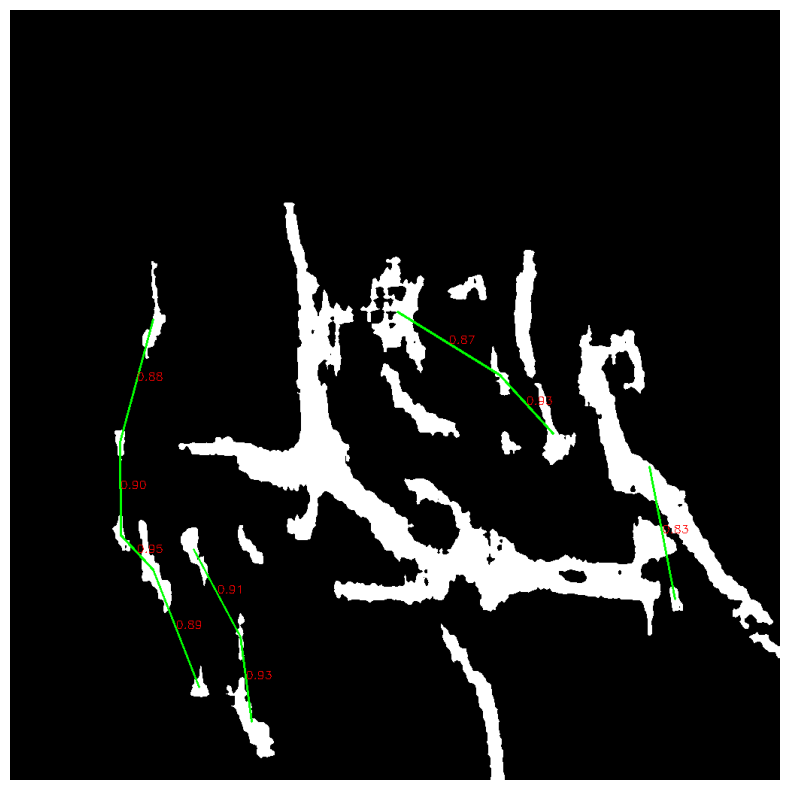

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

def calculate_coordinate_distance(end1, start2):
    return np.linalg.norm(np.array(end1) - np.array(start2))

def calculate_pixel_value_difference(mean_val1, mean_val2):
    return abs(mean_val1 - mean_val2)

def calculate_pca_angle_difference(pca_angle1, pca_angle2):
    pca_angle1 = np.degrees(pca_angle1)
    pca_angle2 = np.degrees(pca_angle2)
    return abs(pca_angle1 - pca_angle2)

def calculate_shape_similarity(contour1, contour2):
    return cv2.matchShapes(np.array(contour1), np.array(contour2), cv2.CONTOURS_MATCH_I1, 0)

def calculate_similarity(node1, node2, normalization_params):
    coordinate_distance = calculate_coordinate_distance(node1['end'], node2['start'])
    pixel_diff = calculate_pixel_value_difference(node1['mean_pixel_value'], node2['mean_pixel_value'])
    pca_angle_diff = calculate_pca_angle_difference(node1['pca_angle'], node2['pca_angle'])


    total_diff = coordinate_distance + pixel_diff + pca_angle_diff 

    max_total_diff = (normalization_params['coordinate_distance_max'] +
                      normalization_params['pixel_diff_max'] +
                      normalization_params['pca_angle_diff_max'])

    total_diff_normalized = total_diff / max_total_diff

    similarity = 1 / (1 + total_diff_normalized)
    
    return similarity

def get_normalization_params(merged_data):
    coordinate_distances, pixel_diffs, pca_angle_diffs, shape_diffs = [], [], [], []
    
    for group in merged_data:
        for node in group['nodes']:
            for edge in node['edges']:
                connected_node = next((n for n in group['nodes'] if n['id'] == edge['connect_node']), None)
                if connected_node:
                    coordinate_distances.append(calculate_coordinate_distance(node['end'], connected_node['start']))
                    pixel_diffs.append(calculate_pixel_value_difference(node['mean_pixel_value'], connected_node['mean_pixel_value']))
                    pca_angle_diffs.append(calculate_pca_angle_difference(node['pca_angle'], connected_node['pca_angle']))

    return {
        'coordinate_distance_max': max(coordinate_distances),
        'pixel_diff_max': max(pixel_diffs),
        'pca_angle_diff_max': max(pca_angle_diffs),
    }

def filter_best_connections(group, normalization_params):
    best_connections = defaultdict(lambda: {"similarity": -1, "node": None})
    selected_connections = {}

    for node in group['nodes']:
        for edge in node['edges']:
            connected_node = next((n for n in group['nodes'] if n['id'] == edge['connect_node']), None)
            if connected_node:
                similarity = calculate_similarity(node, connected_node, normalization_params)
                if similarity > best_connections[node['id']]["similarity"]:
                    best_connections[node['id']] = {"similarity": similarity, "node": connected_node}
    
    for node_id, connection in best_connections.items():
        connected_node = connection["node"]
        if connected_node and connected_node['id'] not in selected_connections:
            selected_connections[connected_node['id']] = (node_id, connection["similarity"])
        elif connected_node:
            if connection["similarity"] > selected_connections[connected_node['id']][1]:
                selected_connections[connected_node['id']] = (node_id, connection["similarity"])

    filtered_edges = []
    for node_id, (selected_node_id, similarity) in selected_connections.items():
        node = next((n for n in group['nodes'] if n['id'] == selected_node_id), None)
        connected_node = next((n for n in group['nodes'] if n['id'] == node_id), None)
        if node and connected_node:
            filtered_edges.append({
                "node1": selected_node_id,
                "node2": node_id,
                "similarity": similarity,
                "start_point": node['center'],
                "end_point": connected_node['center']
            })

    return filtered_edges

def draw_similarity_on_image(merged_data, output_image, threshold=0.8):
    normalization_params = get_normalization_params(merged_data)
    
    color_output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)
    
    for group in merged_data:
        filtered_edges = filter_best_connections(group, normalization_params)

        for edge in filtered_edges:
            if edge["similarity"] >= threshold:
                start_point = tuple(edge['start_point'])
                end_point = tuple(edge['end_point'])

                cv2.line(color_output_image, start_point, end_point, (0, 255, 0), 2)
                mid_x = (start_point[0] + end_point[0]) // 2
                mid_y = (start_point[1] + end_point[1]) // 2
                cv2.putText(color_output_image, f"{edge['similarity']:.2f}", (mid_x, mid_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(color_output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

with open('merged_data.json', 'r') as f:
    merged_data = json.load(f)

draw_similarity_on_image(merged_data, output_image, threshold=0.8)


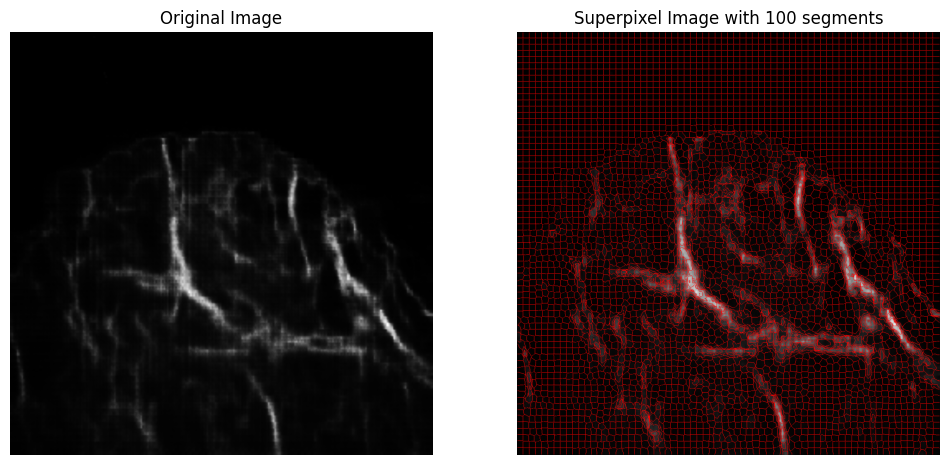

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 불러오기
image = cv2.imread('C:/Users/User/Desktop/image/0-0.png', cv2.IMREAD_GRAYSCALE)

# 2. 이미지 컬러로 변환 (슈퍼픽셀 시각화를 위해)
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# 3. SLIC 알고리즘을 사용하여 슈퍼픽셀 분할 수행
# n_segments는 원하는 슈퍼픽셀의 개수를 설정합니다. 필요에 따라 조정 가능합니다.
n_segments = 100  # 슈퍼픽셀의 개수 (필요에 따라 조정)
superpixel_slic = cv2.ximgproc.createSuperpixelSLIC(image_color, algorithm=cv2.ximgproc.SLIC, region_size=15, ruler=10.0)

# 4. 슈퍼픽셀 분할 적용
superpixel_slic.iterate(10)  # 반복 횟수 설정 (기본값: 10)

# 5. 슈퍼픽셀 마스크 가져오기
mask_slic = superpixel_slic.getLabelContourMask()

# 6. 슈퍼픽셀 라벨 가져오기
labels = superpixel_slic.getLabels()

# 7. 슈퍼픽셀 경계선을 원본 이미지에 표시
contour_image = image_color.copy()
contour_image[mask_slic == 255] = (0, 0, 255)  # 경계선을 빨간색으로 표시

# 8. 결과 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 슈퍼픽셀 경계선 표시된 이미지
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title(f'Superpixel Image with {n_segments} segments')
plt.axis('off')

plt.show()


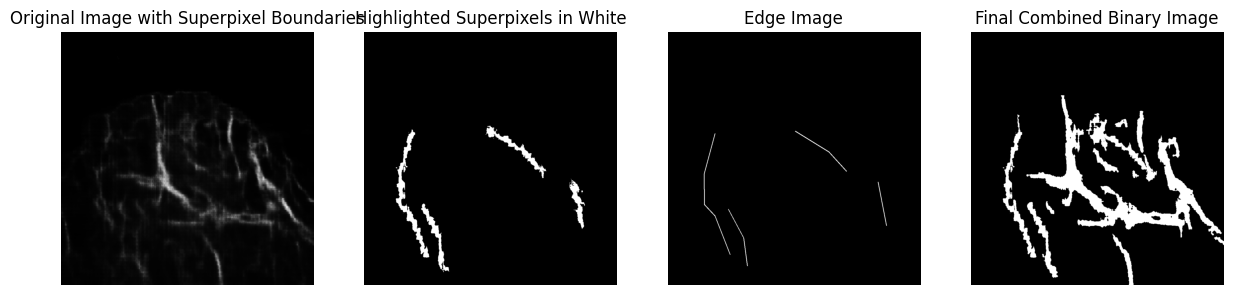

처리된 이미지가 저장되었습니다: C:/Users/User/Desktop/connect_img\0-0.png


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
# 슈퍼픽셀 마스크 생성 함수
def create_superpixel_masks(labels):
    unique_labels = np.unique(labels)
    masks = {label: (labels == label).astype(np.uint8) * 255 for label in unique_labels}
    return masks

# 간선과 슈퍼픽셀의 겹치는 부분을 강조
def find_superpixels_with_edges(edge_image, labels, masks):
    highlighted_superpixels = np.zeros_like(labels, dtype=np.uint8)
    
    # 간선이 있는 영역을 이진화하여 마스크로 생성
    _, edge_mask = cv2.threshold(edge_image, 1, 255, cv2.THRESH_BINARY)
    
    # 각 슈퍼픽셀의 마스크와 간선 마스크의 겹치는 부분을 확인
    for label, mask in masks.items():
        overlap = cv2.bitwise_and(edge_mask, mask)
        if np.any(overlap):
            highlighted_superpixels = cv2.bitwise_or(highlighted_superpixels, mask)
    
    return highlighted_superpixels

# JSON 파일에서 간선 정보 로드 및 이미지에 그리기
def draw_edges_on_image(merged_data, base_image, threshold=0.8):
    color_output_image = base_image.copy()
    
    normalization_params = get_normalization_params(merged_data)
    for group in merged_data:
        filtered_edges = filter_best_connections(group, normalization_params)

        for edge in filtered_edges:
            if edge["similarity"] >= threshold:
                start_point = tuple(edge['start_point'])
                end_point = tuple(edge['end_point'])
                
                # 흰색으로 간선 그리기
                cv2.line(color_output_image, start_point, end_point, (255, 255, 255), 2)

    return color_output_image

# 슈퍼픽셀 생성 및 간선 강조
def process_superpixels_with_edges(image_path, json_file, output_image):
    # 1. 이미지 및 JSON 파일 불러오기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    with open(json_file, 'r') as f:
        merged_data = json.load(f)

    # 2. SLIC 알고리즘으로 슈퍼픽셀 분할 수행
    n_segments = 100
    superpixel_slic = cv2.ximgproc.createSuperpixelSLIC(image_color, algorithm=cv2.ximgproc.SLIC, region_size=15, ruler=10.0)
    superpixel_slic.iterate(10)
    labels = superpixel_slic.getLabels()
    mask_slic = superpixel_slic.getLabelContourMask()
    
    # 3. 슈퍼픽셀 마스크 생성
    superpixel_masks = create_superpixel_masks(labels)

    # 4. 간선이 포함된 이미지 생성
    edges_image = np.zeros_like(image)
    edges_image = draw_edges_on_image(merged_data, edges_image, threshold=0.8)

    # 5. 간선이 포함된 슈퍼픽셀 강조
    highlighted_superpixels = find_superpixels_with_edges(edges_image, labels, superpixel_masks)

    # 6. 간선과 슈퍼픽셀이 겹치는 부분을 `output_image`에 결합
    combined_binary_image = np.zeros_like(output_image, dtype=np.uint8)
    
    # `highlighted_superpixels`과 `output_image` 간의 결합
    if highlighted_superpixels.shape == output_image.shape:
        # 간선과 겹치는 슈퍼픽셀을 `output_image`와 결합
        combined_binary_image = cv2.bitwise_or(output_image, highlighted_superpixels)
    else:
        print("Error: Shape mismatch between `highlighted_superpixels` and `output_image`")

    # 7. 결과 시각화
    plt.figure(figsize=(15, 8))

    # 원본 이미지와 슈퍼픽셀 경계선
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Superpixel Boundaries')
    plt.axis('off')

    # 흰색 슈퍼픽셀만 표시된 이미지
    plt.subplot(1, 4, 2)
    plt.imshow(highlighted_superpixels, cmap='gray')
    plt.title('Highlighted Superpixels in White')
    plt.axis('off')

    # 간선 이미지
    plt.subplot(1, 4, 3)
    plt.imshow(edges_image, cmap='gray')
    plt.title('Edge Image')
    plt.axis('off')

    # 간선과 결합된 최종 이진화 이미지
    plt.subplot(1, 4, 4)
    plt.imshow(combined_binary_image, cmap='gray')
    plt.title('Final Combined Binary Image')
    plt.axis('off')

    plt.show()

    return combined_binary_image

# 실행 예시
image_path = 'C:/Users/User/Desktop/image/0-0.png'
json_file = 'merged_data.json'
output_image  # 이진화된 output_image 불러오기
final_image = process_superpixels_with_edges(image_path, json_file, output_image)

output_folder = 'C:/Users/User/Desktop/connect_img'
output_image_path = os.path.join(output_folder, '0-0.png')
cv2.imwrite(output_image_path, final_image)

print(f"처리된 이미지가 저장되었습니다: {output_image_path}")


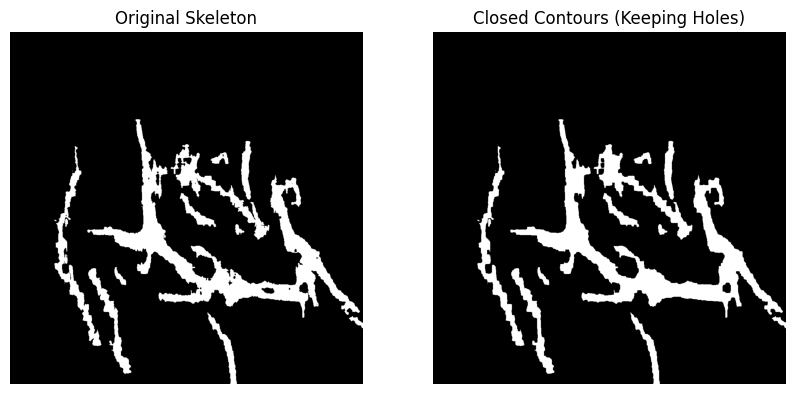

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the binary skeletonized image
skeleton = cv2.imread('C:/Users/User/Desktop/connect_img/0-0.png', 0)  # Load as grayscale

# Ensure the image is binary
_, skeleton_bin = cv2.threshold(skeleton, 127, 255, cv2.THRESH_BINARY)

# Find contours in the skeleton image
contours, _ = cv2.findContours(skeleton_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define the kernel for the closing operation
kernel_size = 3  # Adjust the size to control the effect
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Initialize an empty image to store the results
result_image = np.zeros_like(skeleton_bin)

# Step 1: Apply closing operation to each contour individually
iterations = 3  # You can adjust this value for more or fewer iterations of closing
for contour in contours:
    # Create a mask for the current contour
    contour_mask = np.zeros_like(skeleton_bin)
    
    # Draw only the contour outline, without filling the inside
    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Apply closing to the individual contour, focusing on the outer contour
    closed_contour = cv2.morphologyEx(contour_mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    
    # Combine the closed contour with the original result image
    result_image = cv2.bitwise_or(result_image, closed_contour)

# Step 2: Add the original holes back in to maintain the internal structure
holes = cv2.bitwise_xor(skeleton_bin, result_image)
final_result = cv2.bitwise_or(result_image, holes)

# Step 3: Visualize the original and closed contour images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Closed Contours (Keeping Holes)')
plt.imshow(final_result, cmap='gray')
plt.axis('off')

plt.show()


In [10]:
import cv2
import numpy as np
import sys


# Ensure the image is binary (convert 255 to 1)
binary_array = (final_result > 1).astype(np.uint8)

# Set print options to avoid truncation
np.set_printoptions(threshold=sys.maxsize)
# Save the array to a text file
np.savetxt('C:/Users/User/Desktop/binary_array_output.txt', binary_array, fmt='%d')



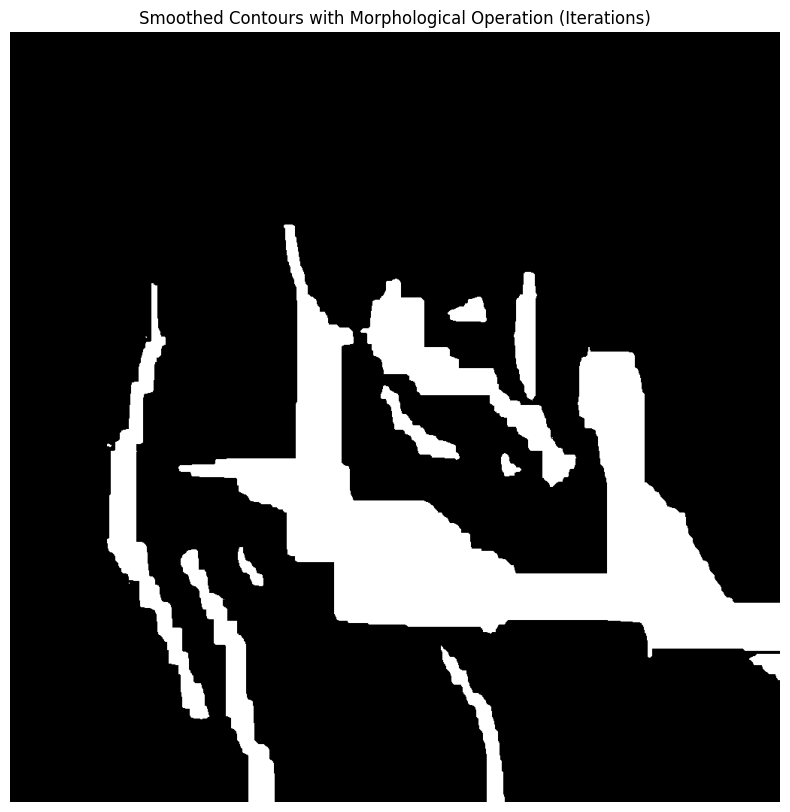

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# Step 1: 원본 이미지에서 개별 컨투어 추출
def extract_contours(image):
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Step 2: 모폴로지 연산으로 컨투어를 부드럽게 하기 위한 함수 (반복 횟수 추가)
def apply_morphology_to_contours(contours, image_size, kernel_size=3, operation='close', iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)  # 모폴로지 연산에 사용할 커널 생성
    
    smoothed_contour_image = np.zeros(image_size, dtype=np.uint8)  # 결과를 담을 빈 이미지
    
    for contour in contours:
        # 개별 컨투어를 담을 빈 이미지 생성
        contour_image = np.zeros(image_size, dtype=np.uint8)

        # 컨투어 그리기
        cv2.drawContours(contour_image, [contour], -1, 255, 1)  # 흰색으로 컨투어 그리기
        
        # 모폴로지 연산 적용 (닫기 또는 열기, 반복 횟수 추가)
        if operation == 'close':
            smoothed_contour = cv2.morphologyEx(contour_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
        elif operation == 'open':
            smoothed_contour = cv2.morphologyEx(contour_image, cv2.MORPH_OPEN, kernel, iterations=iterations)
        else:
            smoothed_contour = contour_image  # 기본적으로 연산을 적용하지 않음

        # 결과 이미지를 합치기
        smoothed_contour_image = cv2.bitwise_or(smoothed_contour_image, smoothed_contour)
    
    return smoothed_contour_image

# Load binary array from file
binary_array = np.loadtxt('C:/Users/User/Desktop/binary_array_output.txt', dtype=np.uint8)

# Convert the binary array (0,1) to an image (0,255) for OpenCV processing
binary_image = binary_array * 255

# Step 1: 원본 이미지에서 개별 컨투어 추출
contours = extract_contours(binary_image)

# Step 2: 모폴로지 연산 적용 (커널 크기, 연산 유형, 반복 횟수 조정 가능)
smoothed_contour_image = apply_morphology_to_contours(contours, binary_image.shape, kernel_size=5, operation='close', iterations=30)

# Step 3: 결과 시각화
plt.figure(figsize=(10, 10))
plt.title('Smoothed Contours with Morphological Operation (Iterations)')
plt.imshow(smoothed_contour_image, cmap='gray')
plt.axis('off')
plt.show()


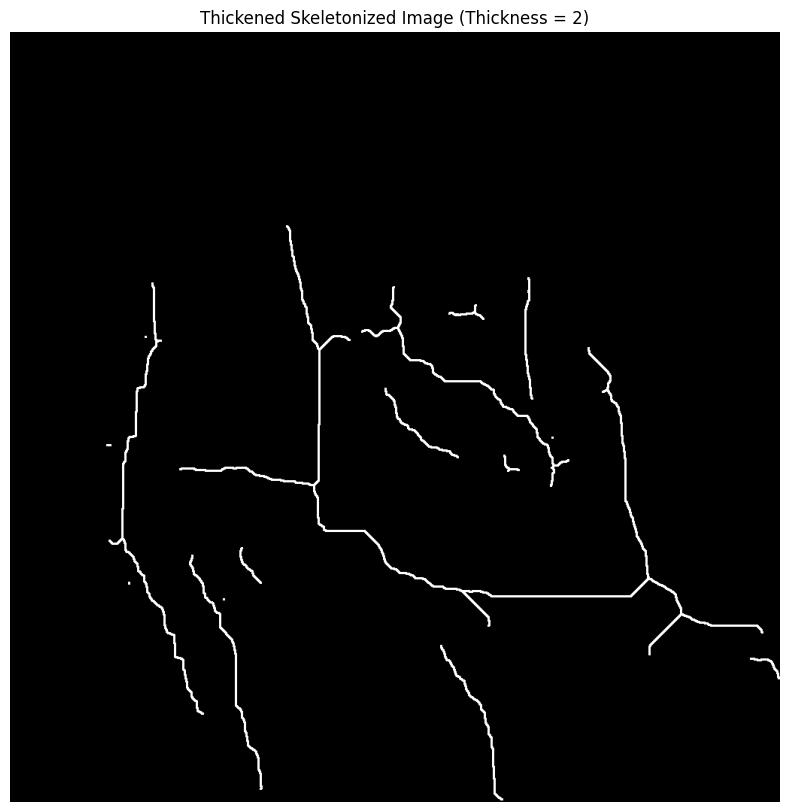

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# Step 1: Skeletonize 이미지
skeleton = skeletonize(smoothed_contour_image // 255).astype(np.uint8) * 255



# Step 4: 선 두께를 2로 조정
kernel = np.ones((3, 3), np.uint8)
thick_skeleton = cv2.dilate(skeleton, kernel, iterations=1)

# Step 5: 결과 시각화
plt.figure(figsize=(10, 10))
plt.title('Thickened Skeletonized Image (Thickness = 2)')
plt.imshow(thick_skeleton, cmap='gray')
plt.axis('off')
plt.show()


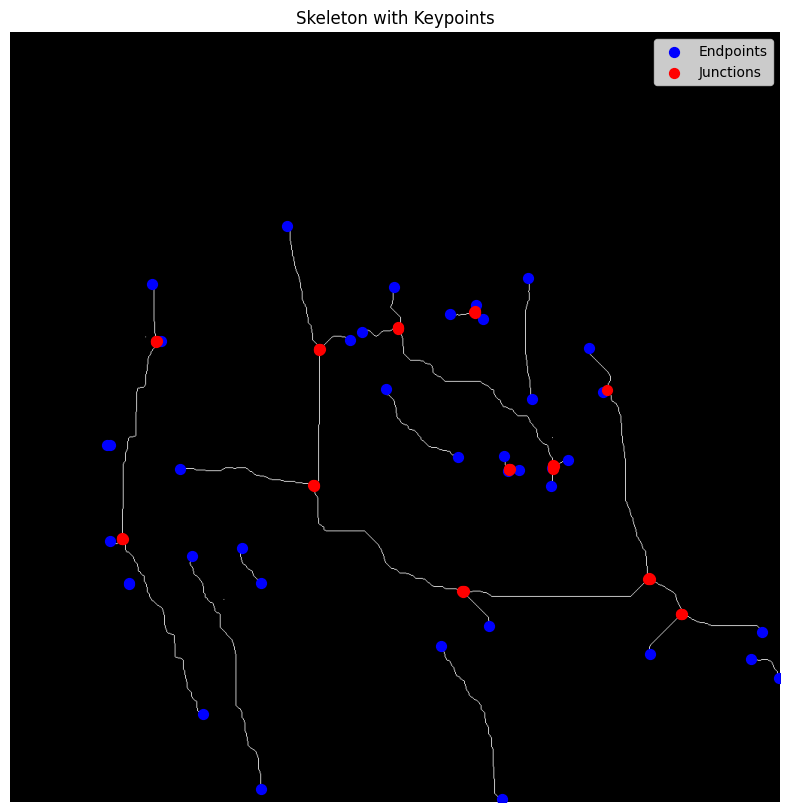

Endpoints: [(258, 368), (327, 689), (334, 189), (339, 510), (363, 619), (374, 584), (381, 629), (398, 468), (409, 451), (410, 200), (420, 769), (474, 499), (478, 788), (487, 694), (549, 129), (549, 133), (563, 657), (565, 595), (569, 742), (579, 720), (581, 226), (582, 676), (583, 662), (603, 719), (676, 132), (686, 308), (696, 242), (732, 158), (732, 333), (733, 158), (789, 636), (798, 1000), (816, 573), (827, 850), (833, 985), (859, 1022), (906, 256), (1006, 333), (1020, 654)]
Junctions: [(371, 618), (372, 617), (372, 618), (373, 618), (392, 516), (393, 515), (393, 516), (394, 516), (410, 194), (411, 194), (411, 195), (412, 194), (421, 410), (421, 411), (421, 412), (422, 411), (475, 794), (575, 722), (576, 722), (576, 723), (577, 722), (578, 722), (579, 721), (579, 722), (580, 663), (580, 722), (581, 663), (581, 664), (582, 663), (602, 403), (602, 404), (603, 404), (673, 149), (674, 148), (674, 149), (674, 150), (726, 849), (727, 848), (727, 849), (727, 850), (743, 601), (743, 602), 

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 기존의 이웃 픽셀 개수를 세는 함수
def count_neighbors(img, x, y):
    neighbors = [
        img[x-1, y-1], img[x-1, y], img[x-1, y+1],  # Top row
        img[x, y-1],               img[x, y+1],    # Middle row (Left and Right)
        img[x+1, y-1], img[x+1, y], img[x+1, y+1]  # Bottom row
    ]
    return sum(n > 0 for n in neighbors)

# 교차점 판단을 위한 함수
def is_junction(img, x, y):
    neighbors = [
        img[x-1, y-1], img[x-1, y], img[x-1, y+1],  # Top row
        img[x, y-1],               img[x, y+1],    # Middle row (Left and Right)
        img[x+1, y-1], img[x+1, y], img[x+1, y+1]  # Bottom row
    ]
    
    # Check if the pixel has at least 3 connected neighbors (indicating a junction)
    connections = [idx for idx, n in enumerate(neighbors) if n > 0]
    if len(connections) >= 3:
        # 이웃한 픽셀들이 불연속적인 방향에 있는지 확인 (비연속적 연결은 교차점일 가능성 높음)
        diffs = [connections[i+1] - connections[i] for i in range(len(connections) - 1)]
        diffs.append(connections[0] + 8 - connections[-1])  # Wrap-around check
        if max(diffs) >= 3:
            return True
    return False

# 교차점과 끝점을 추출하는 함수
def extract_keypoints(skeleton):
    rows, cols = skeleton.shape
    endpoints = []
    junctions = []
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if skeleton[i, j] > 0:  # 스켈레톤 픽셀만 고려
                neighbor_count = count_neighbors(skeleton, i, j)
                if neighbor_count == 1:  # 끝점
                    endpoints.append((i, j))
                elif is_junction(skeleton, i, j):  # 교차점
                    junctions.append((i, j))
                    
    return endpoints, junctions

# Step 1: 스켈레톤화된 이미지로부터 끝점과 교차점 추출
endpoints, junctions = extract_keypoints(skeleton)

# Step 2: 결과 시각화 (스켈레톤 + 끝점 + 교차점)
plt.figure(figsize=(10, 10))
plt.title('Skeleton with Keypoints')

# 스켈레톤 이미지 그리기
plt.imshow(skeleton, cmap='gray')

# 끝점은 파란색, 교차점은 빨간색으로 표시
for endpoint in endpoints:
    plt.scatter(endpoint[1], endpoint[0], color='blue', s=50, label='Endpoints' if 'Endpoints' not in plt.gca().get_legend_handles_labels()[1] else "")
for junction in junctions:
    plt.scatter(junction[1], junction[0], color='red', s=50, label='Junctions' if 'Junctions' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.axis('off')
plt.show()

# 결과 출력
print("Endpoints:", endpoints)
print("Junctions:", junctions)


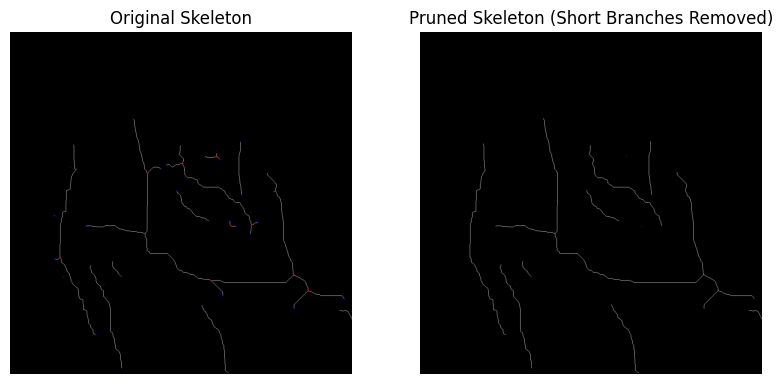

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# Step 2: Define a function to count 8-connected neighbors
def count_neighbors(img, x, y):
    neighbors = [
        img[x-1, y-1], img[x-1, y], img[x-1, y+1],  # Top row
        img[x, y-1],               img[x, y+1],    # Left and Right
        img[x+1, y-1], img[x+1, y], img[x+1, y+1]  # Bottom row
    ]
    return sum(n > 0 for n in neighbors)  # Count non-zero neighbors

# Step 3: Create arrays for junctions and endpoints
junctions = np.zeros_like(skeleton)
endpoints = np.zeros_like(skeleton)

# Step 4: Iterate through the skeleton and mark junctions and endpoints
rows, cols = skeleton.shape
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if skeleton[i, j] > 0:  # Only consider skeleton pixels
            neighbor_count = count_neighbors(skeleton, i, j)
            if neighbor_count == 1:  # Endpoint
                endpoints[i, j] = 255
            elif neighbor_count >= 3:  # Junction
                junctions[i, j] = 255

# Step 5: Function to trace from an endpoint to a junction
def trace_path_from_endpoint(skeleton, junctions, x, y):
    path = [(x, y)]  # Initialize path with the starting endpoint
    visited = set()  # Track visited pixels to avoid loops
    visited.add((x, y))

    # Define 8-connected neighbors
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    while True:
        found_next = False
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < skeleton.shape[0] and 0 <= ny < skeleton.shape[1]:
                if skeleton[nx, ny] > 0 and (nx, ny) not in visited:  # Unvisited skeleton pixel
                    path.append((nx, ny))
                    visited.add((nx, ny))
                    x, y = nx, ny
                    found_next = True
                    break  # Move to the next pixel
        
        if not found_next or junctions[x, y] > 0:  # Stop if no next pixel or junction is reached
            break
    
    return path

# Step 6: Trace paths from all endpoints to junctions
paths = []
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if endpoints[i, j] > 0:  # Start from each endpoint
            path = trace_path_from_endpoint(skeleton, junctions, i, j)
            if len(path) > 1:  # If a path was found
                paths.append(path)

# Step 7: Define a minimum length for branches
min_branch_length = 50  # Define a minimum length for a branch to be kept

# Step 8: Remove short branches
pruned_skeleton = skeleton.copy()  # Start with the original skeleton
for path in paths[:-1]:
    if len(path) < min_branch_length:  # If the branch is too short, remove it
        for pixel in path:
            pruned_skeleton[pixel[0], pixel[1]] = 0  # Set the pixel value to 0 (remove it)

# Step 9: Increase the size of junctions and endpoints (make them thicker)
kernel = np.ones((2, 2), np.uint8)  # Kernel for dilation
junctions_dilated = cv2.dilate(junctions, kernel, iterations=2)  # Dilate junctions
endpoints_dilated = cv2.dilate(endpoints, kernel, iterations=2)  # Dilate endpoints

# Step 10: Convert the skeleton image to color for visualizing junctions and endpoints
skeleton_colored = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)

# Step 11: Mark junctions in red
skeleton_colored[junctions_dilated > 0] = [255, 0, 0]  # Red color for junctions

# Step 12: Mark endpoints in blue
skeleton_colored[endpoints_dilated > 0] = [0, 0, 255]  # Blue color for endpoints

# Step 13: Visualize the original and pruned skeleton images
plt.figure(figsize=(15, 10))

# Plot original skeleton
plt.subplot(1, 3, 1)
plt.title('Original Skeleton')
plt.imshow(skeleton_colored)
plt.axis('off')

# Plot pruned skeleton
plt.subplot(1, 3, 2)
plt.title('Pruned Skeleton (Short Branches Removed)')
plt.imshow(pruned_skeleton, cmap='gray')
plt.axis('off')



plt.show()


이미지 저장 완료: C:/Users/User/Desktop/final/0-0.png와 thickened_skeleton_only.png


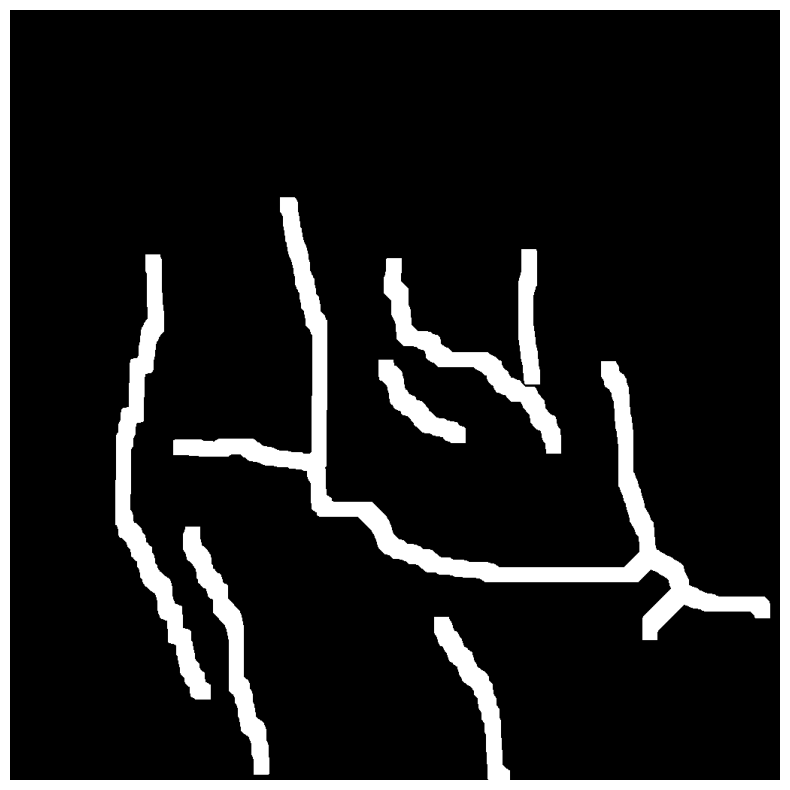

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 작은 객체 제거 함수
def remove_small_objects(image, min_size):
    # 연결 성분 분석
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    # 새 이미지를 만들어서 작은 객체들만 제거
    cleaned_image = np.zeros_like(image)

    for i in range(1, num_labels):  # 라벨 0은 배경이므로 제외
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            cleaned_image[labels == i] = 255  # 면적이 min_size 이상인 객체만 남김

    return cleaned_image

# Step 1: 스켈레톤화된 이미지로부터 작은 객체 제거
min_object_size = 100  # 최소 객체 크기 (픽셀 수)
cleaned_skeleton = remove_small_objects(pruned_skeleton, min_object_size)

# Step 2: 스켈레톤 선을 굵게 하기 위해 팽창 연산 적용 (굵기를 10으로 설정)
kernel = np.ones((20, 20), np.uint8)  # 굵기를 10으로 설정하는 커널
thickened_skeleton = cv2.dilate(cleaned_skeleton, kernel, iterations=1)


# Step 4: 결과 시각화 (굵어진 스켈레톤 + 끝점 + 교차점)
plt.figure(figsize=(10, 10))
plt.imshow(thickened_skeleton, cmap='gray')


# 축 제거
plt.axis('off')

# Step 5: 이미지 파일로 저장 (PNG 형식)
output_path = "C:/Users/User/Desktop/final/0-0.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

# OpenCV로 이미지 저장 (흑백 이미지 저장)
cv2.imwrite("0-0.png", thickened_skeleton)

# 저장 완료 메시지 출력
print(f"이미지 저장 완료: {output_path}와 thickened_skeleton_only.png")


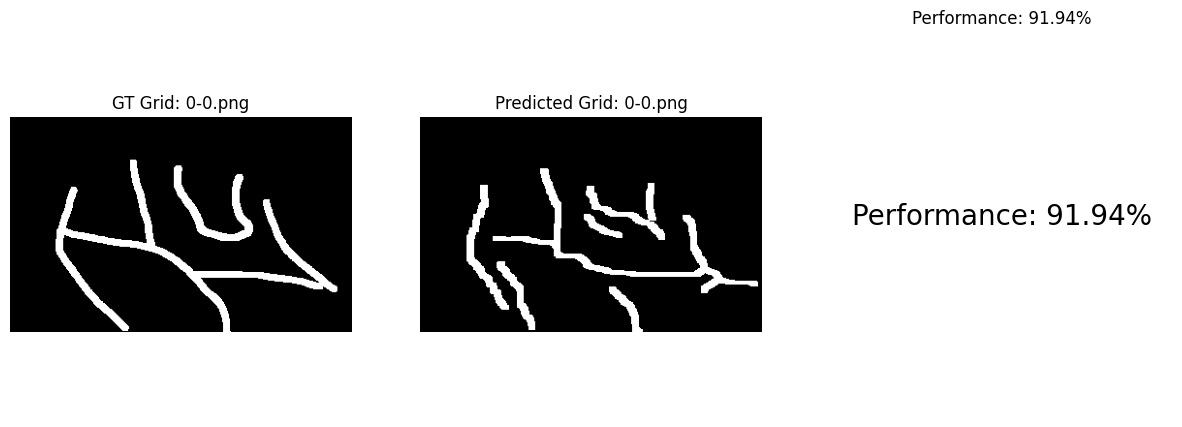

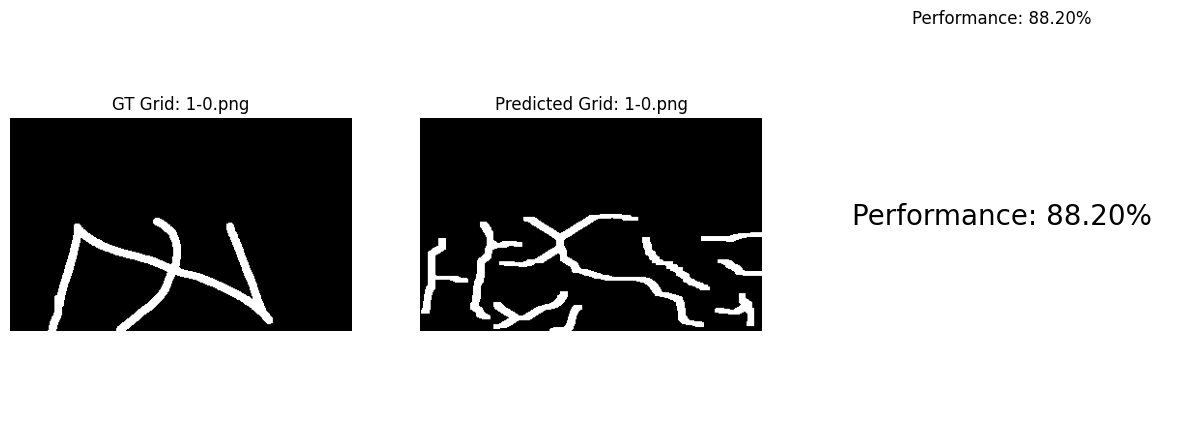

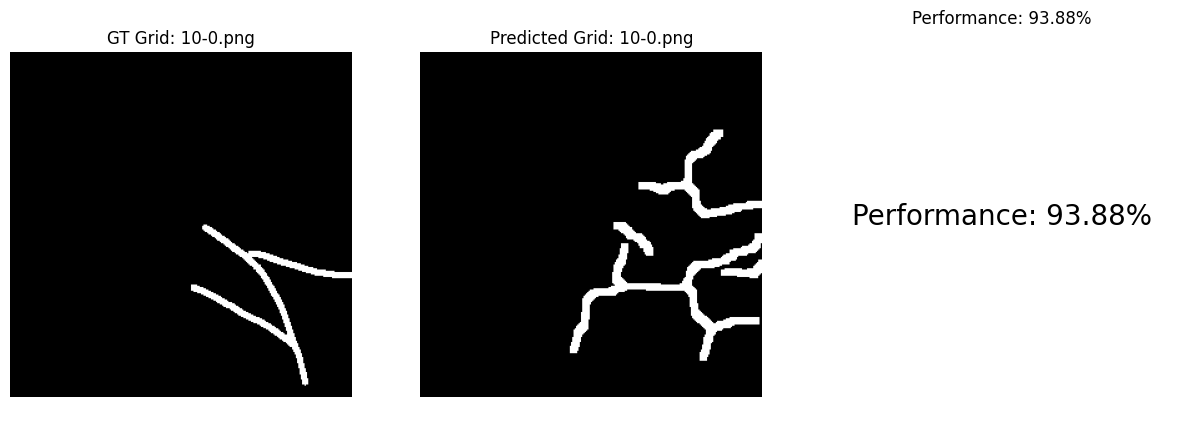

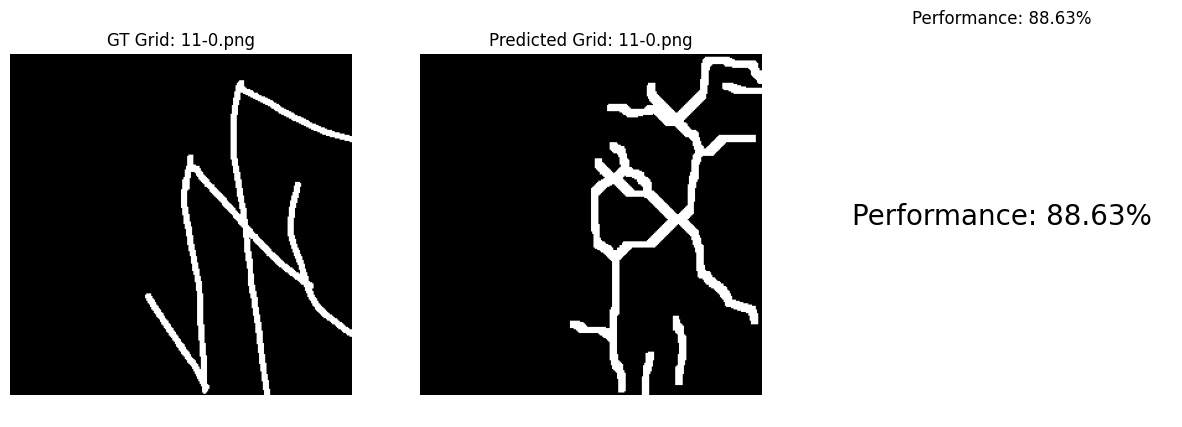

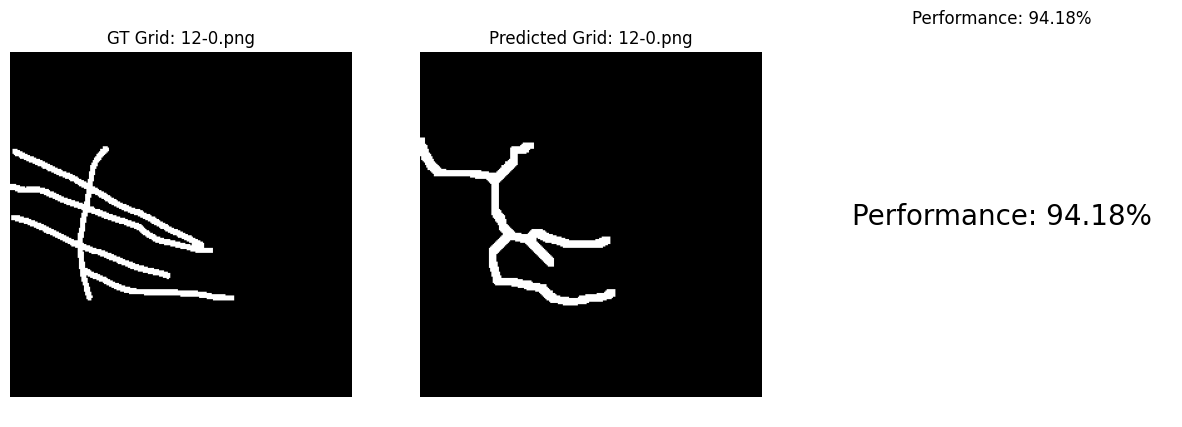

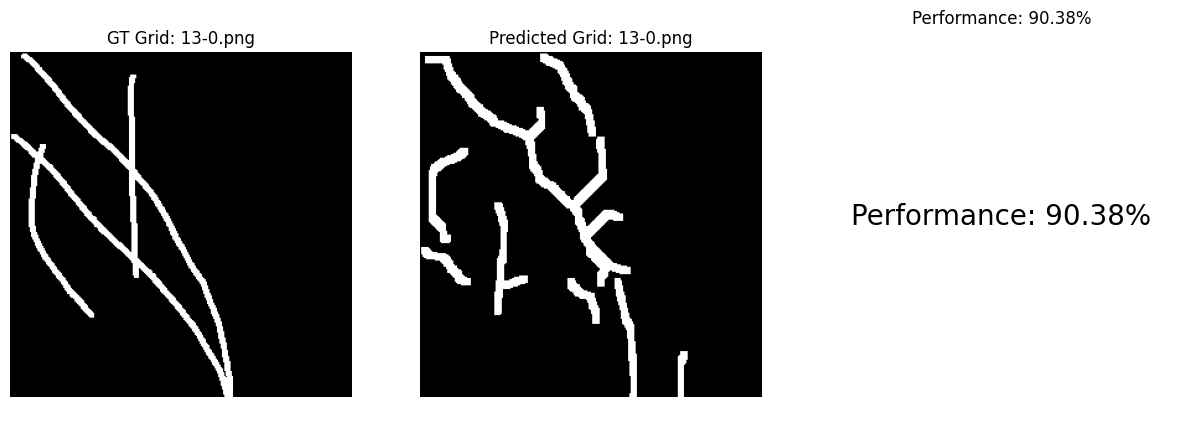

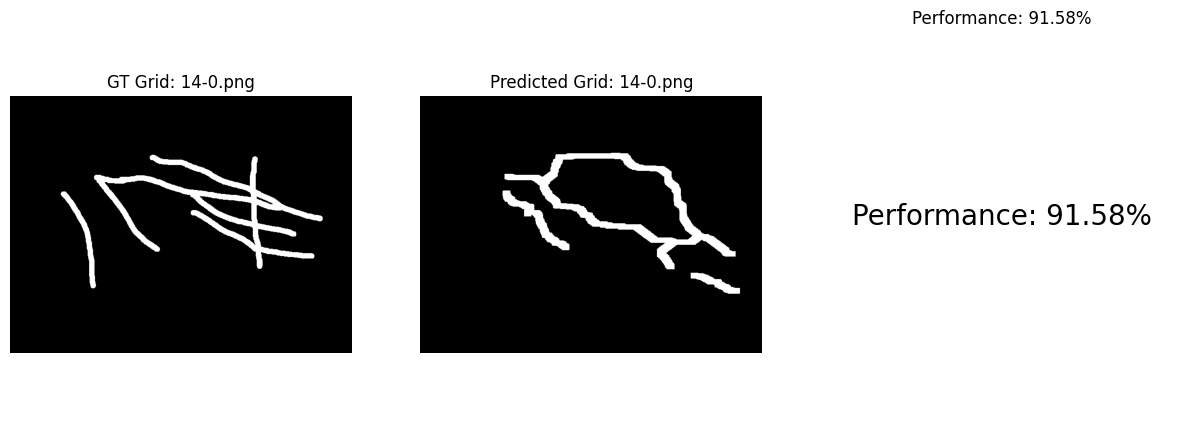

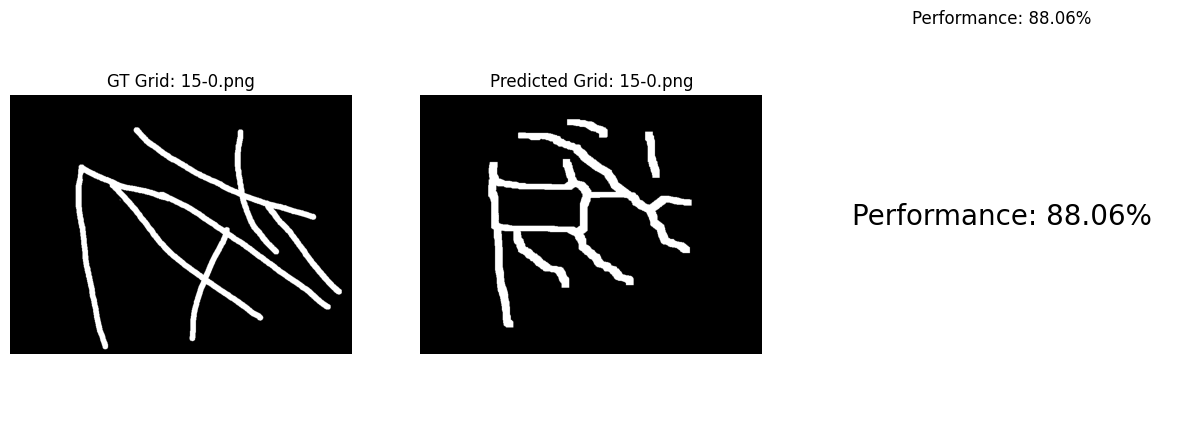

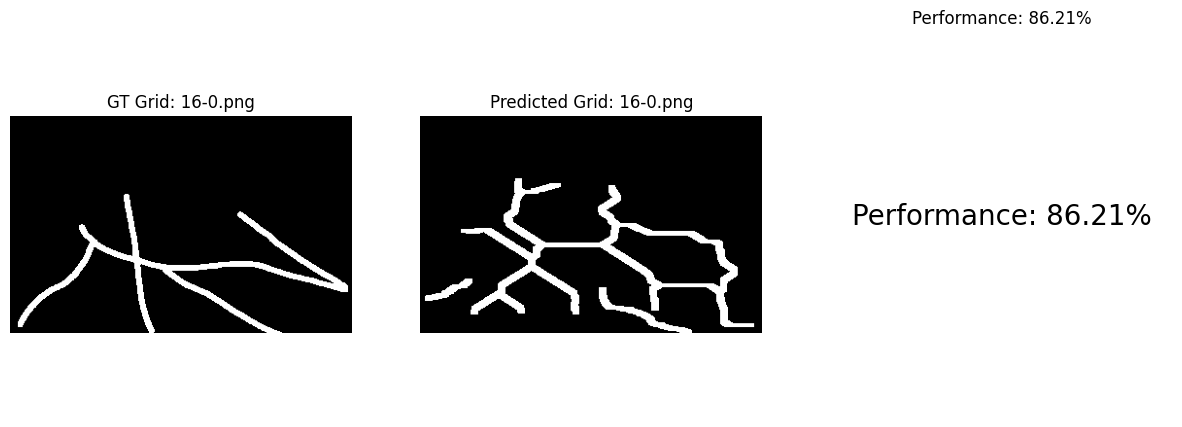

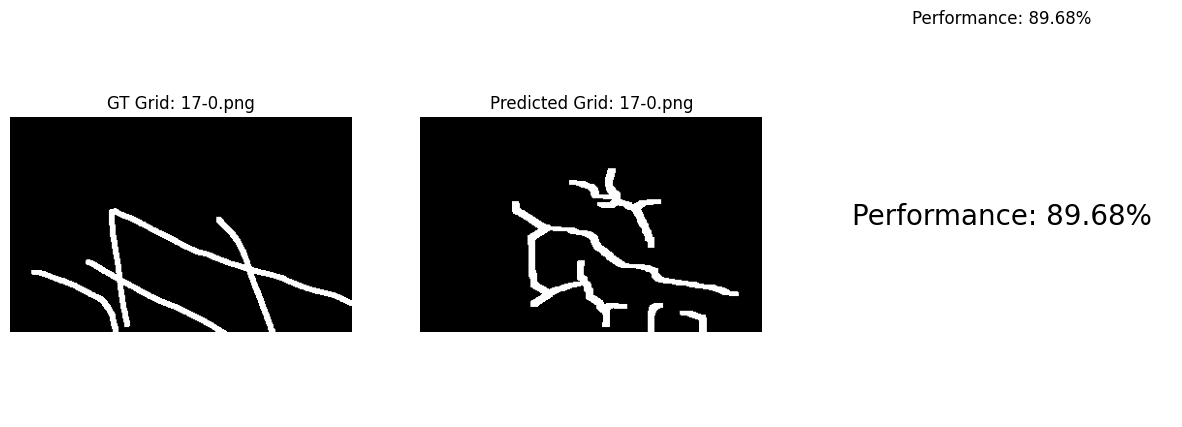

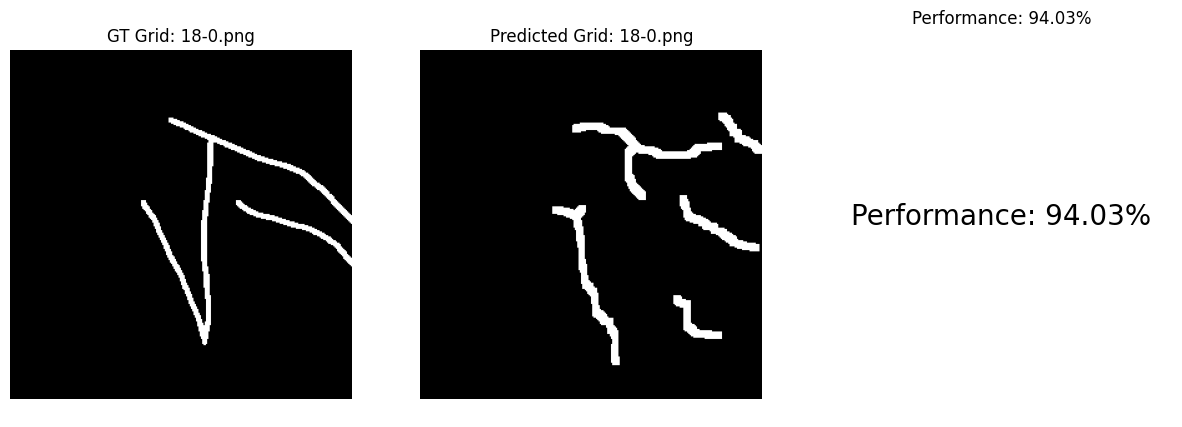

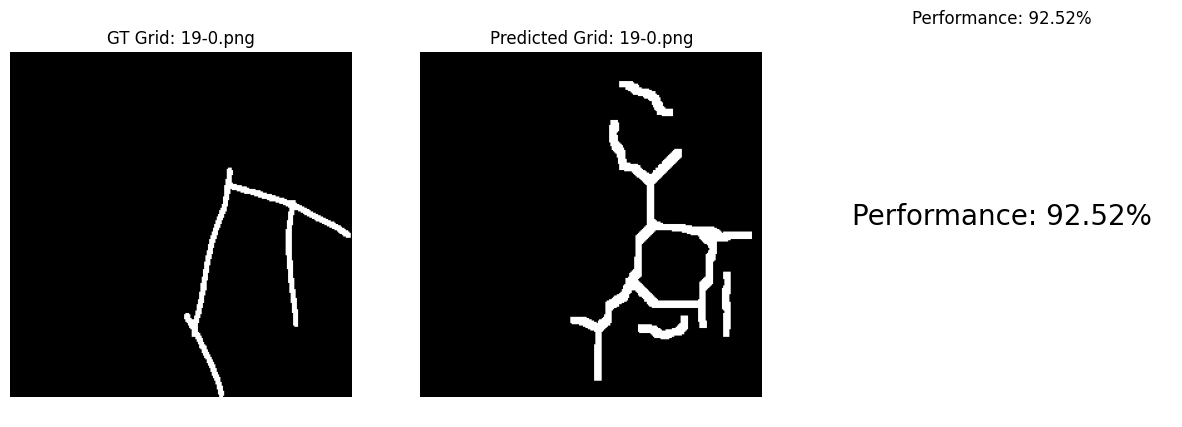

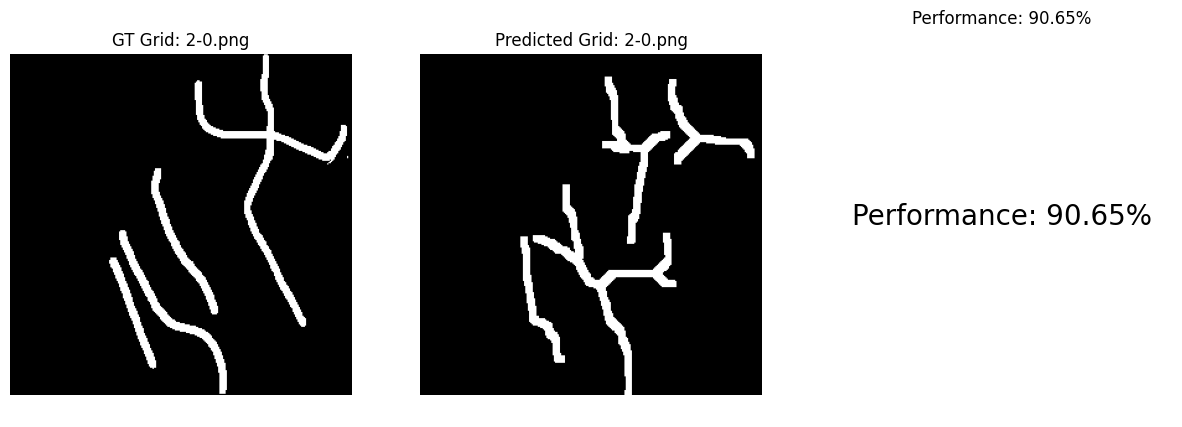

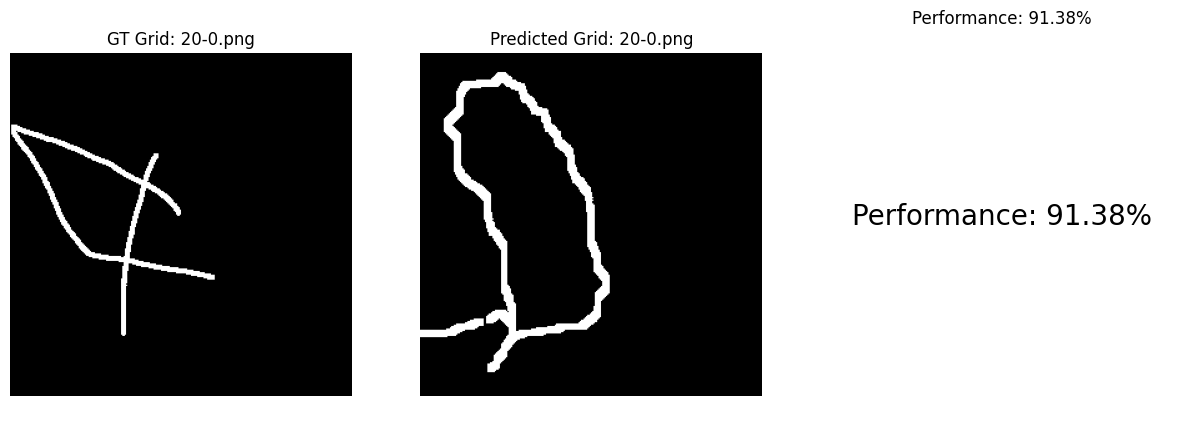

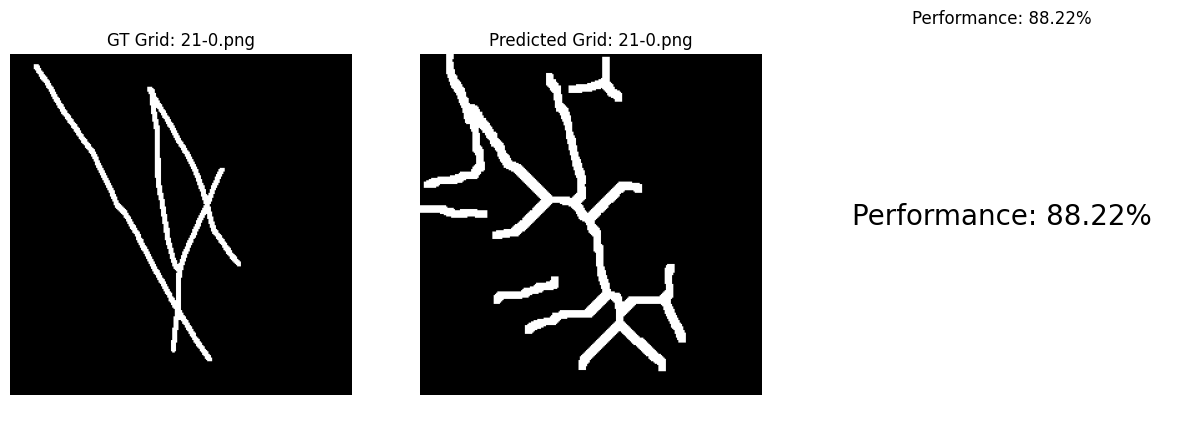

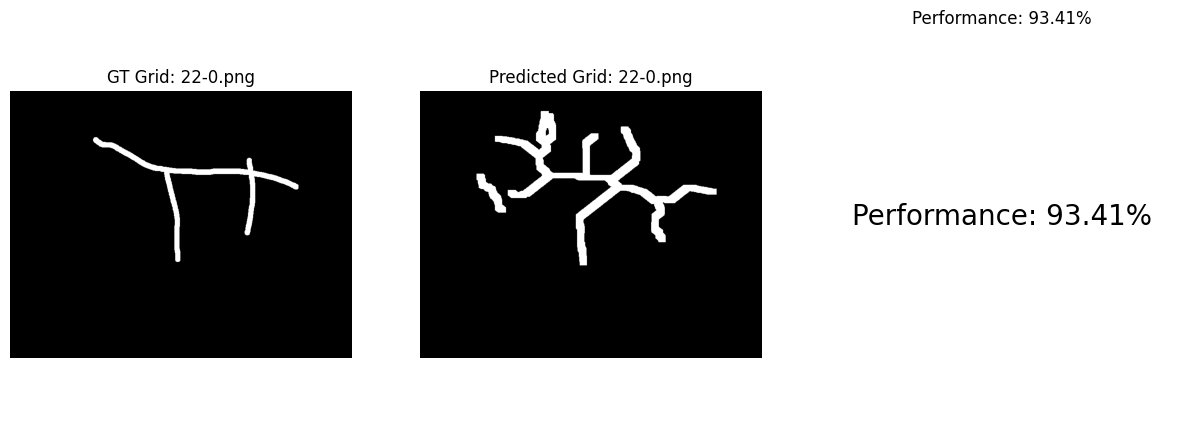

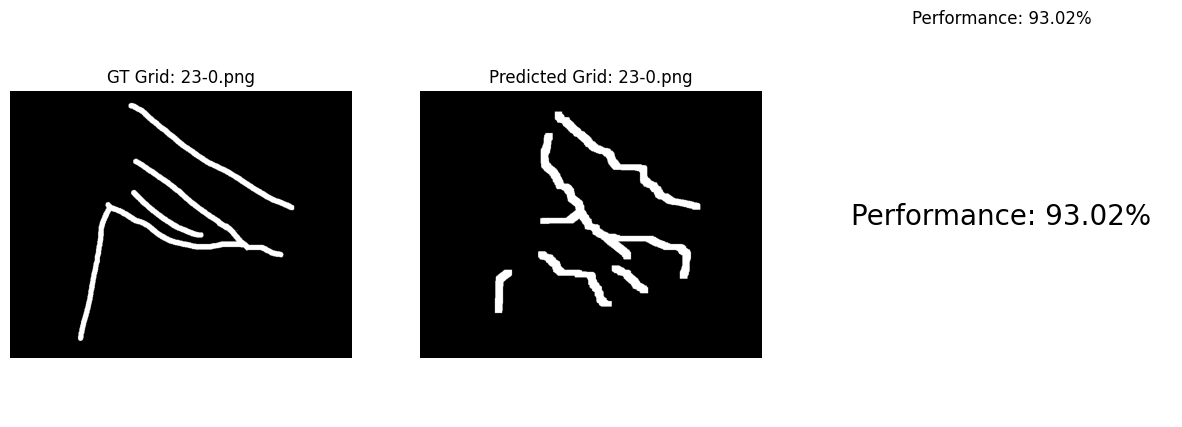

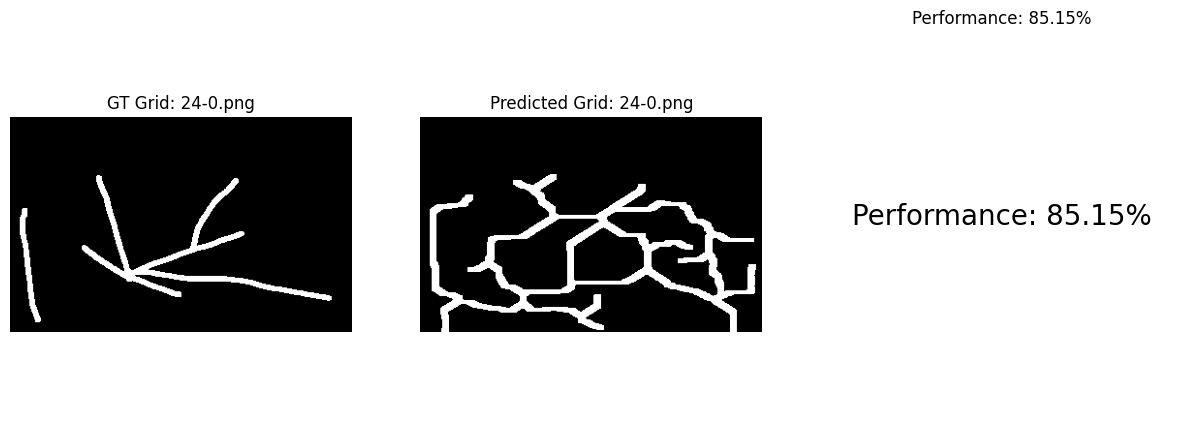

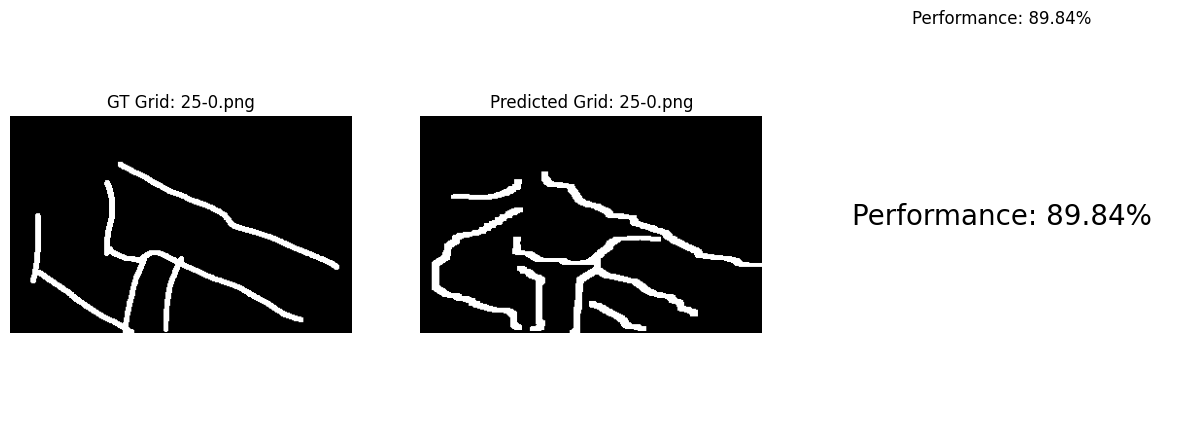

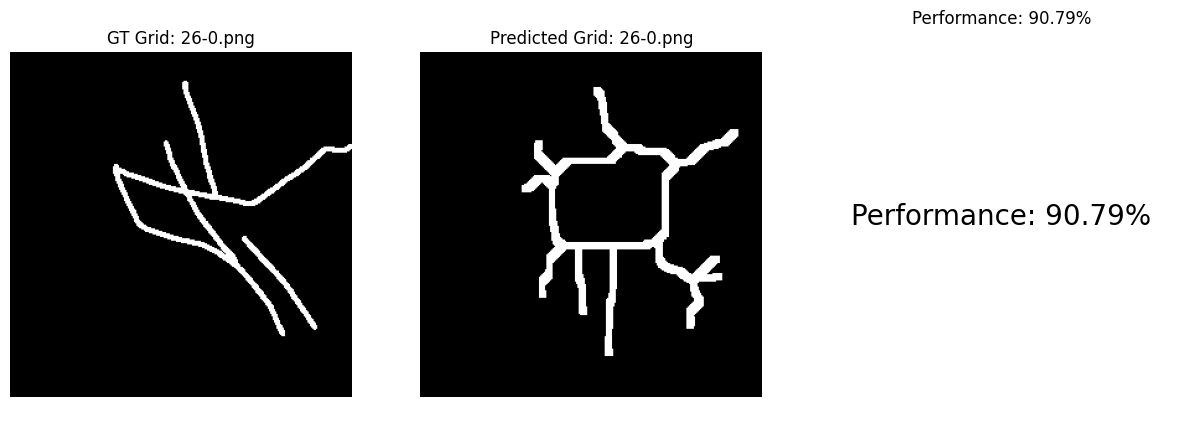

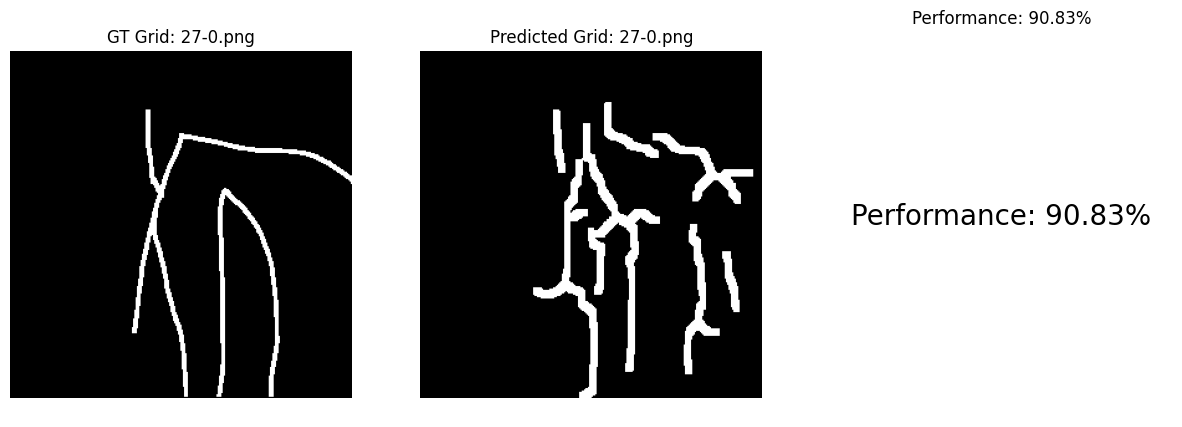

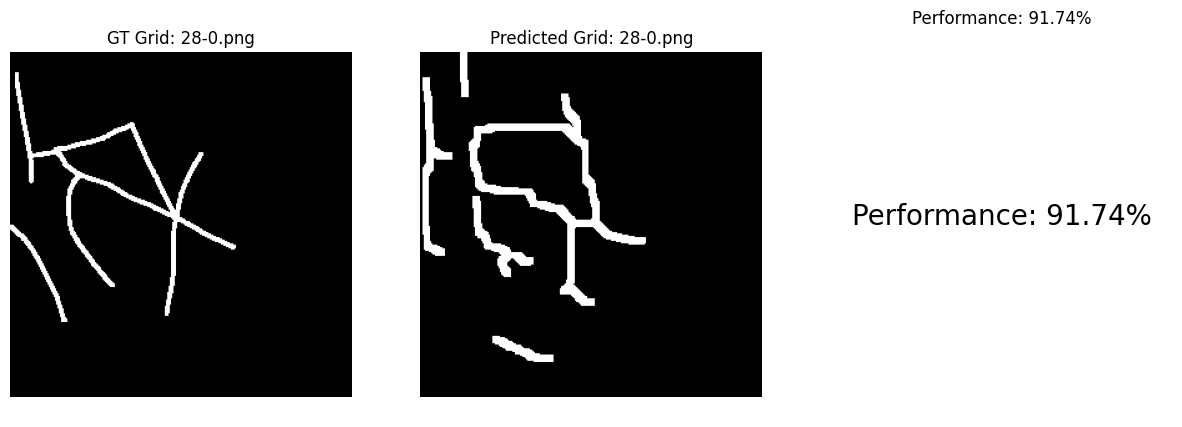

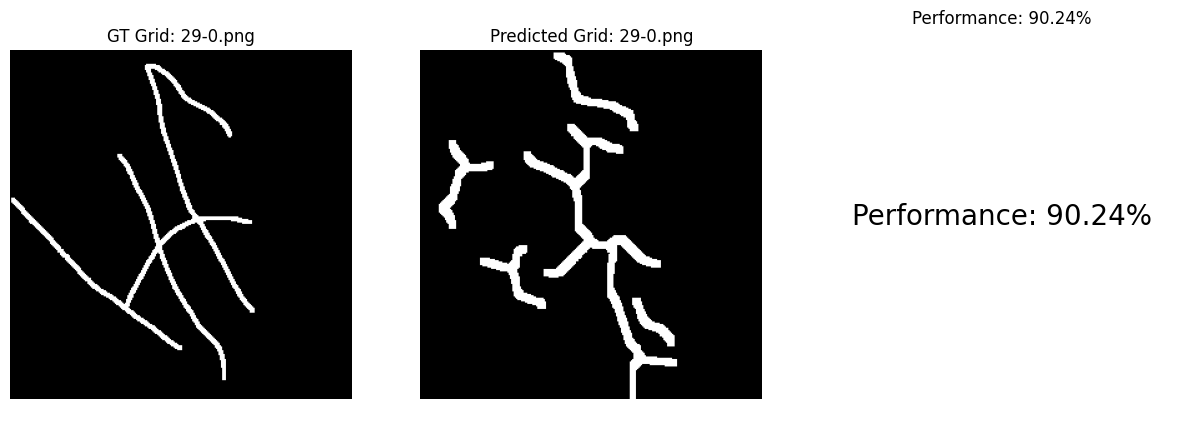

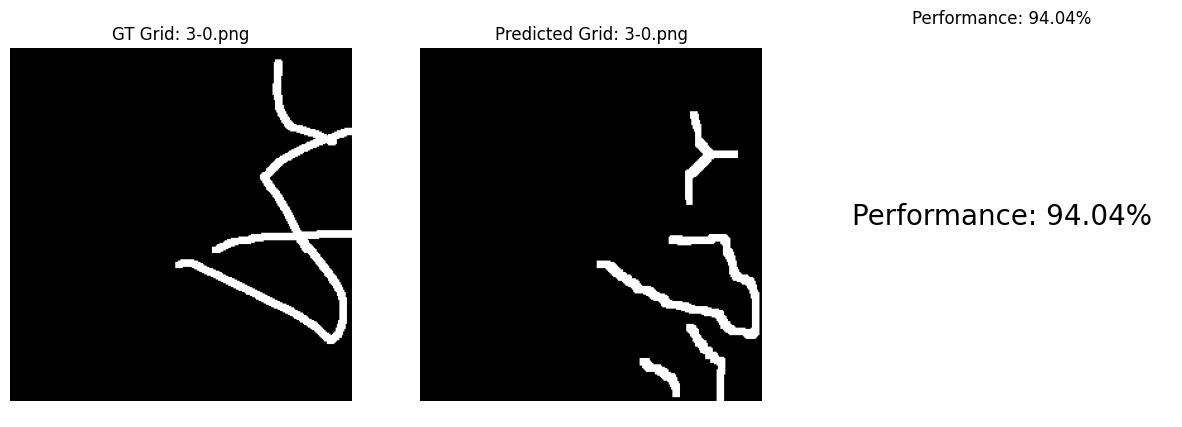

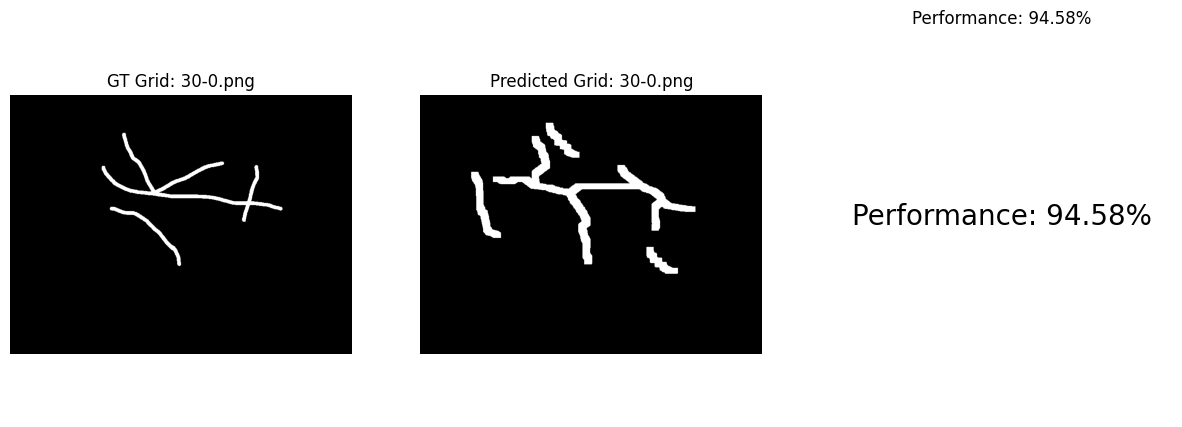

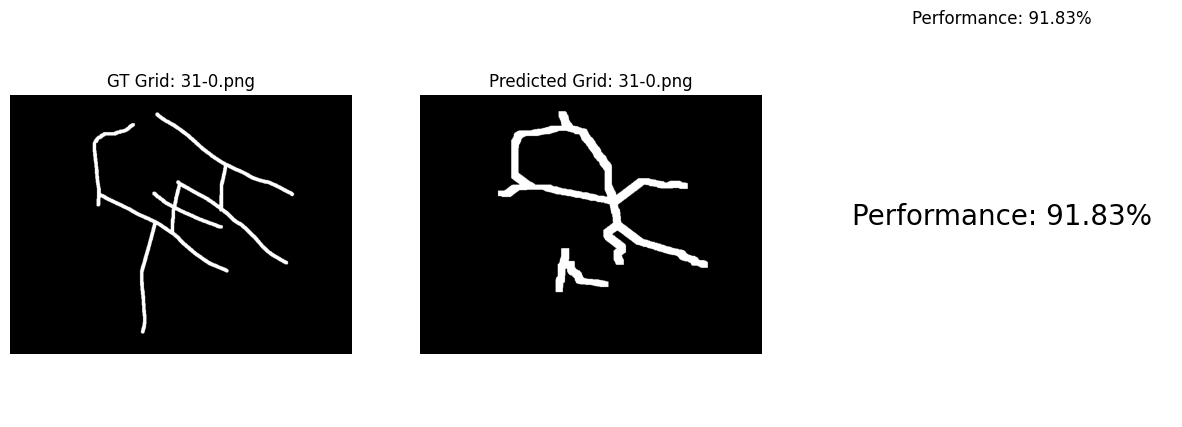

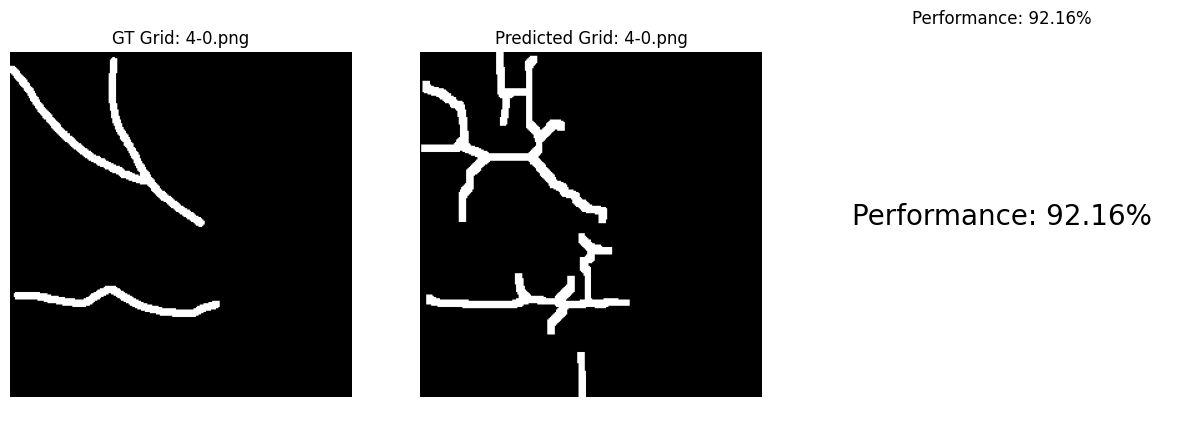

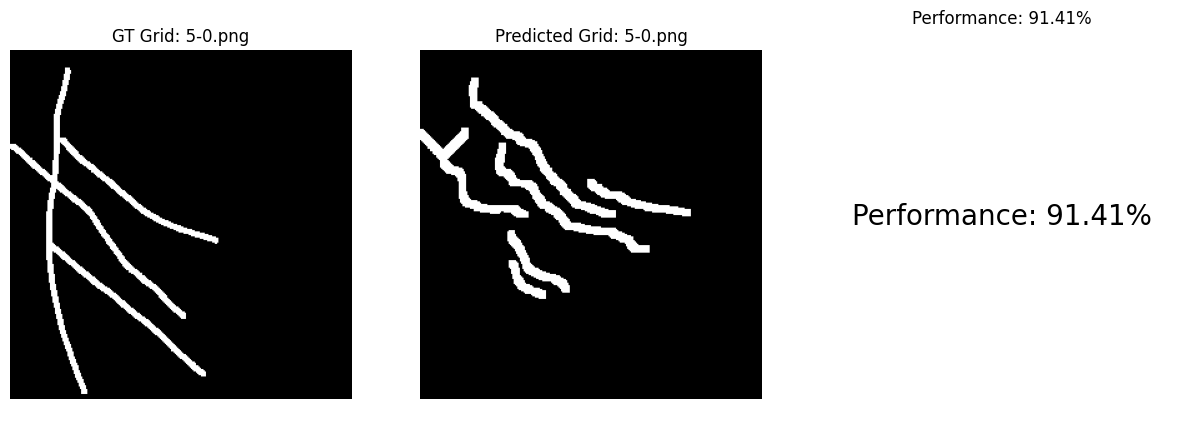

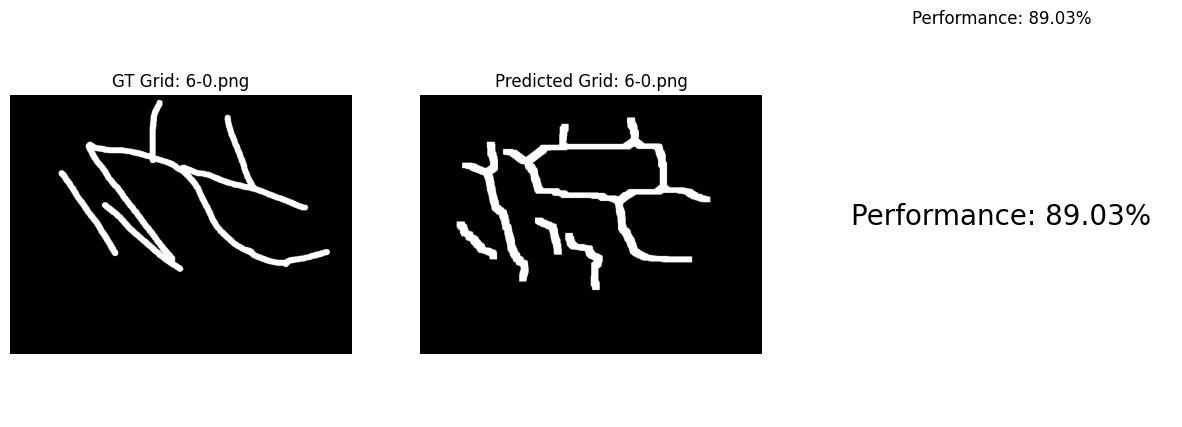

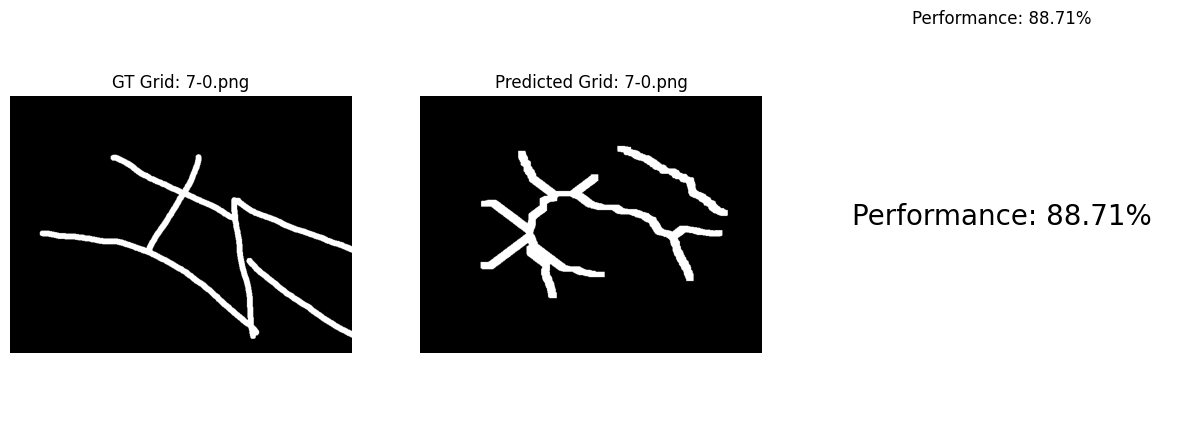

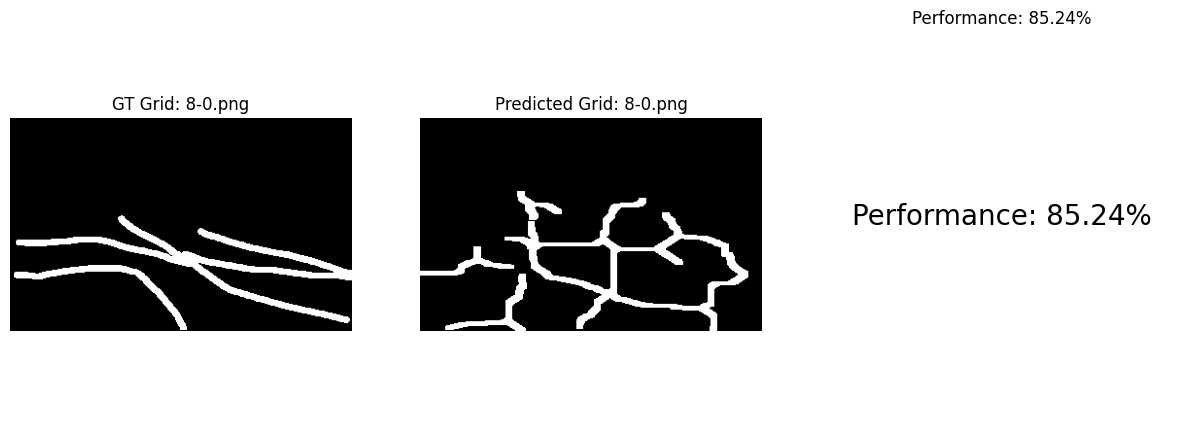

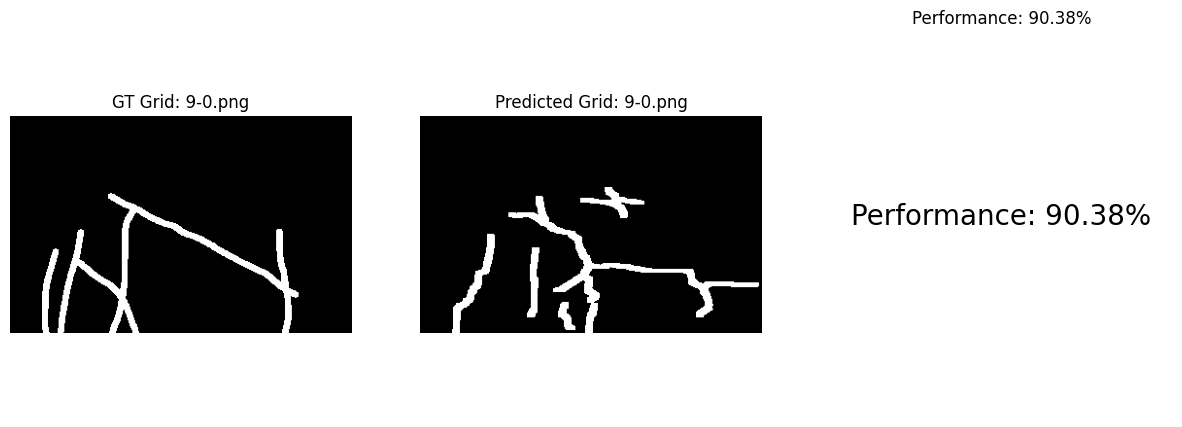

전체 성능 평가 결과: 91.06%
Performance for 0-0.png: 91.94%
Performance for 1-0.png: 88.20%
Performance for 10-0.png: 93.88%
Performance for 11-0.png: 88.63%
Performance for 12-0.png: 94.18%
Performance for 13-0.png: 90.38%
Performance for 14-0.png: 91.58%
Performance for 15-0.png: 88.06%
Performance for 16-0.png: 86.21%
Performance for 17-0.png: 89.68%
Performance for 18-0.png: 94.03%
Performance for 19-0.png: 92.52%
Performance for 2-0.png: 90.65%
Performance for 20-0.png: 91.38%
Performance for 21-0.png: 88.22%
Performance for 22-0.png: 93.41%
Performance for 23-0.png: 93.02%
Performance for 24-0.png: 85.15%
Performance for 25-0.png: 89.84%
Performance for 26-0.png: 90.79%
Performance for 27-0.png: 90.83%
Performance for 28-0.png: 91.74%
Performance for 29-0.png: 90.24%
Performance for 3-0.png: 94.04%
Performance for 30-0.png: 94.58%
Performance for 31-0.png: 91.83%
Performance for 4-0.png: 92.16%
Performance for 5-0.png: 91.41%
Performance for 6-0.png: 89.03%
Performance for 7-0.png: 88.71

In [34]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# GT와 예측 이미지가 저장된 폴더 경로
gt_folder = 'C:/Users/User/Desktop/test_gt'   # GT 이미지 폴더
pred_folder = pred_folder = 'C:/Users/User/Desktop/final'  # 예측 이미지 폴더

# Step 1: Define grid size
grid_size = 2  # 그리드 크기
threshold = 0.5  # 불연속면 비율 임계값

# 불연속면을 확인하는 함수에서 임계값 적용
def check_for_discontinuity(block, threshold=0.2):
    non_zero_count = np.count_nonzero(block)
    total_pixels = block.size
    proportion = non_zero_count / total_pixels
    return 1 if proportion > threshold else 0

# Step 2: List all files in the GT folder and match with predicted images
gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith('.png')])
pred_files = sorted([f for f in os.listdir(pred_folder) if f.endswith('.png')])

# 성능 평가 결과 저장을 위한 리스트
performances = []
total_matching_regions = 0
total_regions = 0

# Step 3: Iterate over the files and perform grid-based comparison
for gt_file, pred_file in zip(gt_files, pred_files):
    # GT와 예측 이미지 로드
    gt_image = cv2.imread(os.path.join(gt_folder, gt_file), cv2.IMREAD_GRAYSCALE)
    pred_image = cv2.imread(os.path.join(pred_folder, pred_file), cv2.IMREAD_GRAYSCALE)
    
    # 이미지 크기가 다르면 리사이즈
    height, width = gt_image.shape
    height = (height // grid_size) * grid_size  # Ensure divisibility
    width = (width // grid_size) * grid_size
    gt_image_resized = cv2.resize(gt_image, (width, height))
    pred_image_resized = cv2.resize(pred_image, (width, height))
    
    # 그리드 크기에 맞춘 이진화된 결과 배열
    gt_grid = np.zeros((height // grid_size, width // grid_size), dtype=np.uint8)
    pred_grid = np.zeros_like(gt_grid)
    
    # 그리드 기반으로 불연속면 확인
    for i in range(0, height, grid_size):
        for j in range(0, width, grid_size):
            gt_block = gt_image_resized[i:i+grid_size, j:j+grid_size]
            pred_block = pred_image_resized[i:i+grid_size, j:j+grid_size]
            gt_grid[i//grid_size, j//grid_size] = check_for_discontinuity(gt_block, threshold)
            pred_grid[i//grid_size, j//grid_size] = check_for_discontinuity(pred_block, threshold)
    
    # Step 4: 성능 평가 계산
    matching_regions = np.sum(gt_grid == pred_grid)
    total_regions_image = gt_grid.size
    performance = matching_regions / total_regions_image
    performances.append((gt_file, performance))
    
    # 전체 성능 정산을 위한 누적 계산
    total_matching_regions += matching_regions
    total_regions += total_regions_image

    # 개별 성능 평가 결과 시각화
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f'GT Grid: {gt_file}')
    plt.imshow(gt_grid, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f'Predicted Grid: {pred_file}')
    plt.imshow(pred_grid, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Performance: {performance*100:.2f}%')
    plt.text(0.5, 0.5, f'Performance: {performance*100:.2f}%', fontsize=20, ha='center')
    plt.axis('off')

    plt.show()

# Step 5: 전체 성능 평가 결과 출력
total_performance = total_matching_regions / total_regions
print(f'전체 성능 평가 결과: {total_performance*100:.2f}%')

# 개별 이미지 성능 평가 결과 출력
for filename, perf in performances:
    print(f"Performance for {filename}: {perf*100:.2f}%")
